# Prediction_of_H1N1_vaccination
Your task is to predict whether people got H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors.



## Data Understanding

### Import Libraries and Data

In [14]:
import pandas as pd
import numpy as np
import scipy
import itertools
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from IPython.display import clear_output
import category_encoders
try:
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
except:
    !pip install autoimpute
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

from lightgbm import plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
clear_output();
%matplotlib inline


In [15]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
submission = pd.read_csv('../Prediction_of_H1N1_vaccination/data/submission.csv')

In [16]:
train.shape, target.shape, test.shape, submission.shape

((42154, 38), (42154, 2), (28104, 38), (28104, 2))

In [17]:
df=pd.concat([train,target],axis=1)
df.shape

(42154, 40)

#### Duplicates

In [18]:
# duplicates
df.duplicated().sum()

229

In [19]:
# drop duplicates
df = df.drop_duplicates().reset_index(drop=True)
train = df[train.columns]
target = df[target.columns]
df.duplicated().sum()

0

In [20]:
# feature duplicates having different targets
train.duplicated(keep=False).sum()

411

In [21]:
max_acc = (train.shape[0]-train.duplicated(keep=False).sum())/train.shape[0]*100
print(f'maximum accuracy from this data = {max_acc}%')

maximum accuracy from this data = 99.01967799642219%


In [22]:
# drop all because I won't collect external feature
dup = train.duplicated(keep=False)
df = df.drop(dup[dup].index).reset_index(drop=True)
train = df[train.columns]
target = df[target.columns]
train.duplicated(keep=False).sum()

0

In [23]:
df.shape

(41514, 40)

In [24]:
def data_init():
    train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
    target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
    df=pd.concat([train,target],axis=1)
    df = df.drop_duplicates().reset_index(drop=True)
    train = df[train.columns]
    target = df[target.columns]
    dup = train.duplicated(keep=False)
    df = df.drop(dup[dup].index).reset_index(drop=True)
    train = df[train.columns]
    target = df[target.columns]
    return df, train, target

In [25]:
df, train, target = data_init()

#### Random seed

In [26]:
random_seed=42
np.random.seed(random_seed)

### Data Describe and EDA

#### Pandas Profiling

In [27]:
#ProfileReport(df, title="Pandas Profiling Report", explorative=True)

#### Univariate analysis

Including Data re-expression, type casting, Outliers

In [28]:
def EDA_plot1(df,column):  
    df[column].value_counts(sort=False)[::-1].plot(kind='bar',title=column+'counts')
    pd.crosstab(df[column],df['vacc_h1n1_f'],normalize='columns').plot(kind='bar',title=column + ' distribution by target')

In [29]:
type_feature={}

##### (target) vacc_h1n1_f

- Description : Whether respondent received H1N1 flu vaccine.

<AxesSubplot:title={'center':'vacc_h1n1_f'}>

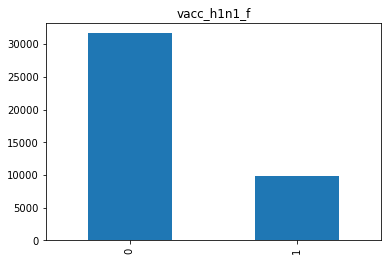

In [30]:
df['vacc_h1n1_f'].value_counts().plot(kind='bar',title='vacc_h1n1_f')

- Note : Nominal, Imbalanced Data

In [31]:
type_feature['vacc_h1n1_f'] = 'bool'

##### vacc_seas_f

- Description : Whether respondent received seasonal flu vaccine.

<AxesSubplot:title={'center':'vacc_seas_f'}>

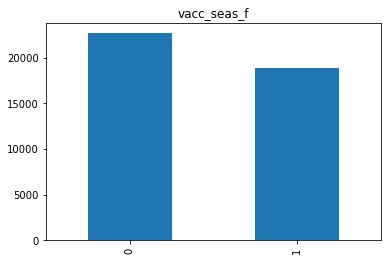

In [32]:
df['vacc_seas_f'].value_counts().plot(kind='bar',title='vacc_seas_f')

- Note : boolean, Imbalanced Data, dependent variable

In [33]:
type_feature['vacc_seas_f'] = 'bool'

##### h1n1_concern 

- Description : Level of concern about the H1N1 flu.   
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.   

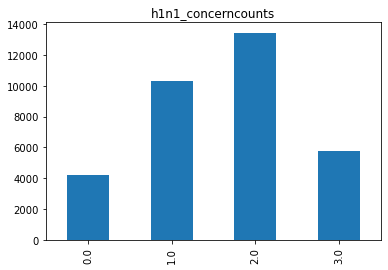

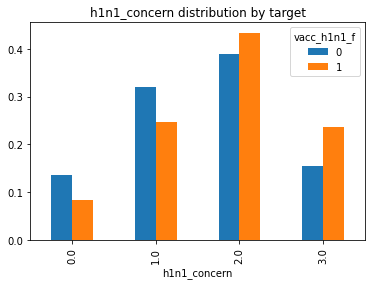

In [34]:
EDA_plot1(df,'h1n1_concern')

- Note : ordinal type

In [35]:
type_feature['h1n1_concern'] = 'ordinal'

##### h1n1_knowledge

- Description : Level of knowledge about H1N1 flu.   
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.   

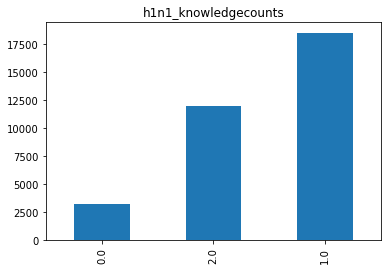

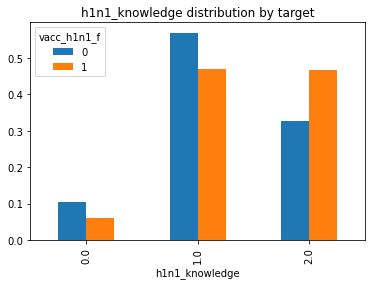

In [36]:
EDA_plot1(df,'h1n1_knowledge')

- Note : Disordered

In [37]:
type_feature['h1n1_knowledge'] = 'nominal'

##### behavioral_antiviral_meds

- Description : Has taken antiviral medications.

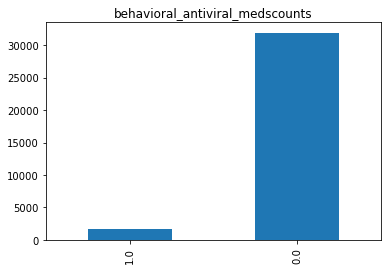

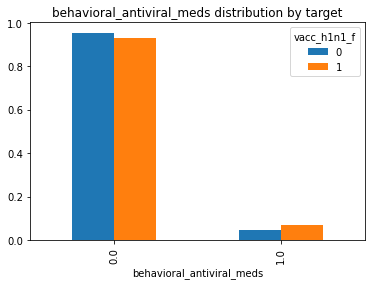

In [38]:
EDA_plot1(df,'behavioral_antiviral_meds')

- Note : boolean

In [39]:
type_feature['behavioral_antiviral_meds'] = 'bool'

##### behavioral_avoidance

- Description : Has avoided close contact with others with flu-like symptoms.

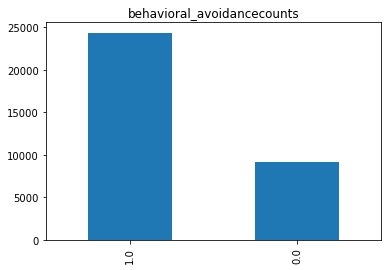

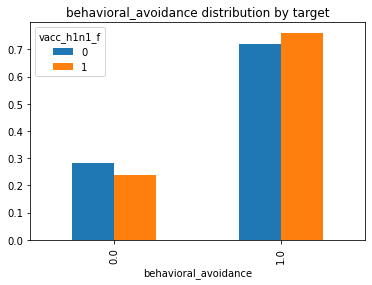

In [40]:
EDA_plot1(df,'behavioral_avoidance')

- Note : boolean

In [41]:
type_feature['behavioral_avoidance'] = 'bool'

##### behavioral_face_mask

- Description : Has bought a face mask.

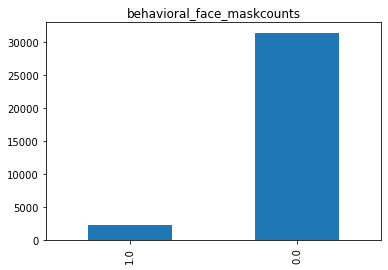

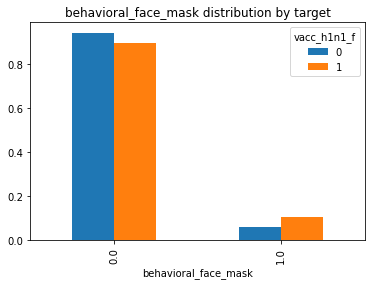

In [42]:
EDA_plot1(df,'behavioral_face_mask')

- Note : boolean

In [43]:
type_feature['behavioral_face_mask'] = 'bool'

##### behavioral_wash_hands

- Description : Has frequently washed hands or used hand sanitizer.

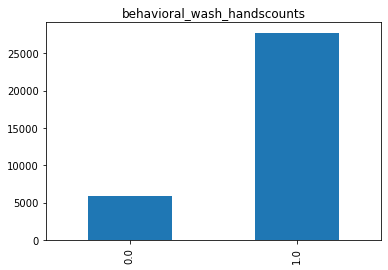

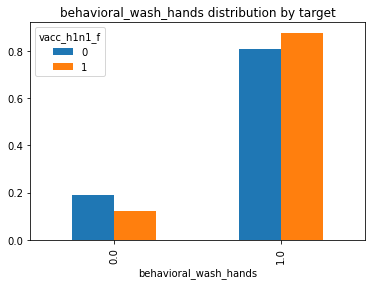

In [44]:
EDA_plot1(df,'behavioral_wash_hands')

- Note : boolean

In [45]:
type_feature['behavioral_wash_hands'] = 'bool'

##### behavioral_large_gatherings

- Description : Has reduced time at large gatherings.

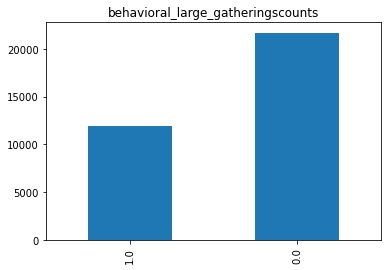

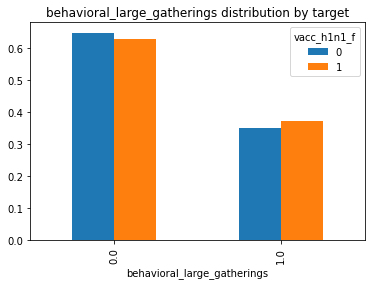

In [46]:
EDA_plot1(df,'behavioral_large_gatherings')

- Note : boolean

In [47]:
type_feature['behavioral_large_gatherings'] = 'bool'

##### behavioral_outside_home

- Description : Has reduced contact with people outside of own household.

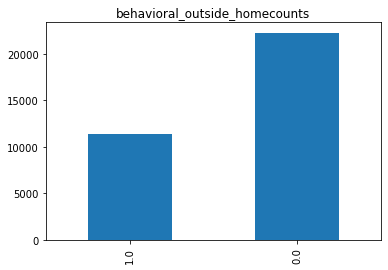

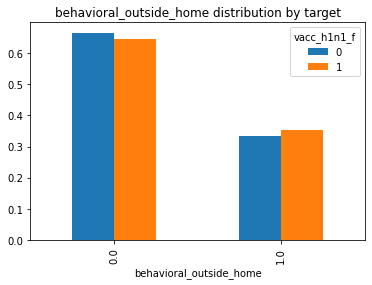

In [48]:
EDA_plot1(df,'behavioral_outside_home')

- Note : boolean

In [49]:
type_feature['behavioral_outside_home'] = 'bool'

##### behavioral_touch_face

- Description : Has avoided touching eyes, nose, or mouth.

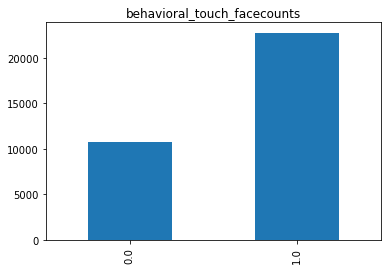

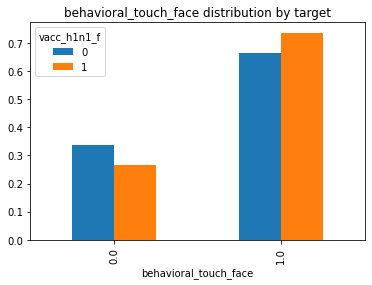

In [50]:
EDA_plot1(df,'behavioral_touch_face')

- Note : boolean

In [51]:
type_feature['behavioral_touch_face'] = 'bool'

##### doctor_recc_h1n1

- Description : H1N1 flu vaccine was recommended by doctor.

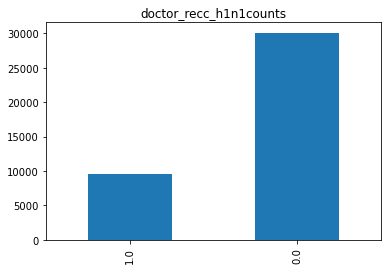

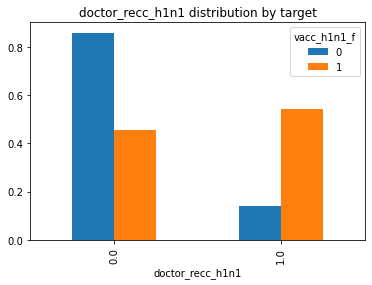

In [52]:
EDA_plot1(df,'doctor_recc_h1n1')

In [53]:
type_feature['doctor_recc_h1n1'] = 'bool'

- Note : boolean, significant difference

##### doctor_recc_seasonal

- Description : Seasonal flu vaccine was recommended by doctor.

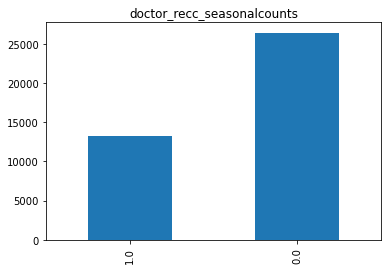

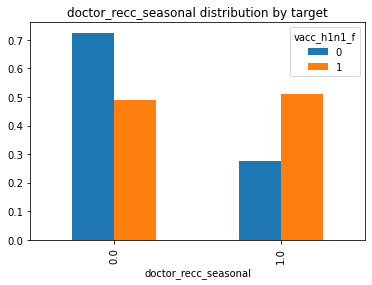

In [54]:
EDA_plot1(df,'doctor_recc_seasonal')

- Note : boolean, seasonal, significant difference

In [55]:
type_feature['doctor_recc_seasonal'] = 'bool'

##### chronic_med_condition

- Description : Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. 

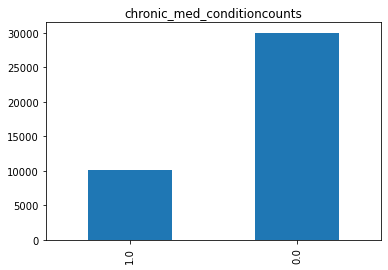

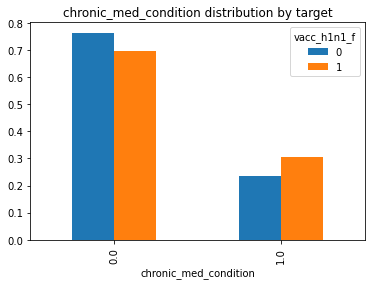

In [56]:
EDA_plot1(df,'chronic_med_condition')

- Note : boolean

In [57]:
type_feature['chronic_med_condition'] = 'bool'

##### child_under_6_months

- Description : Has regular close contact with a child under the age of six months.

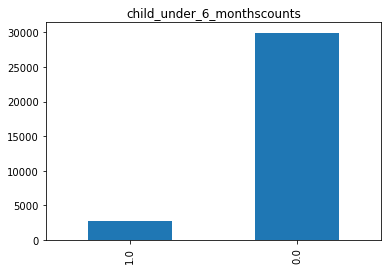

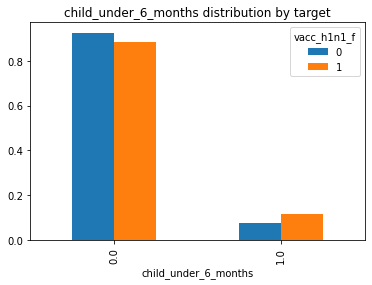

In [58]:
EDA_plot1(df,'child_under_6_months')

- Note : boolean

In [59]:
type_feature['child_under_6_months'] = 'bool'

##### health_insurance

- Description : Has health insurance.

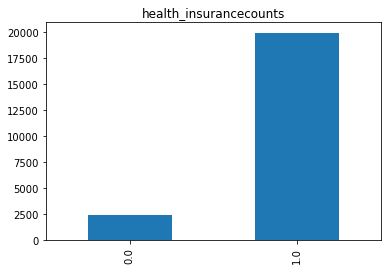

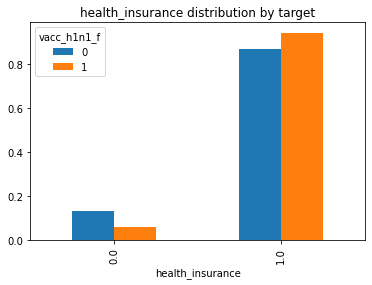

In [60]:
EDA_plot1(df,'health_insurance')

- Note : boolean

In [61]:
type_feature['health_insurance'] = 'bool'

##### health_worker

- Description : Is a healthcare worker.

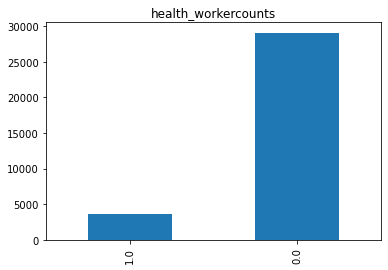

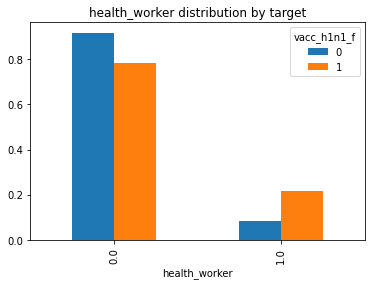

In [62]:
EDA_plot1(df,'health_worker')

- Note : boolean

In [63]:
type_feature['health_worker'] = 'bool'

##### opinion_h1n1_vacc_effective

- Description : Respondent's opinion about H1N1 vaccine effectiveness.   

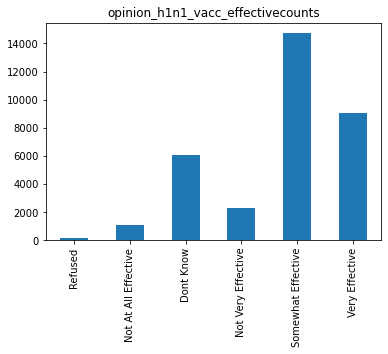

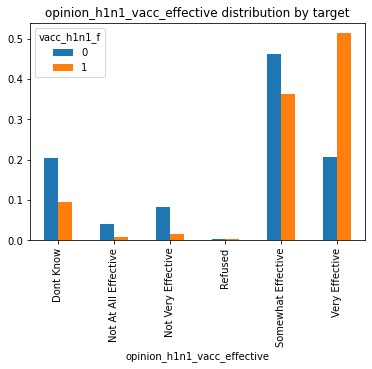

In [64]:
EDA_plot1(df,'opinion_h1n1_vacc_effective')

- Note : Disordered

In [65]:
type_feature['opinion_h1n1_vacc_effective'] = 'nominal'

##### opinion_h1n1_risk

- Description : Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.  

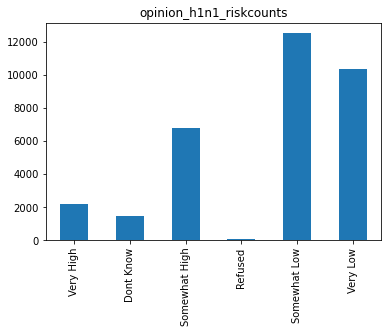

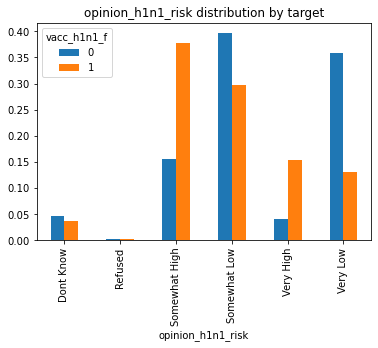

In [66]:
EDA_plot1(df,'opinion_h1n1_risk')

- Note : ordinal type, dont know/refused -> 3

In [67]:
type_feature['opinion_h1n1_risk'] = 'nominal' # change later

##### opinion_h1n1_sick_from_vacc

- Description : Respondent's worry of getting sick from taking H1N1 vaccine.   

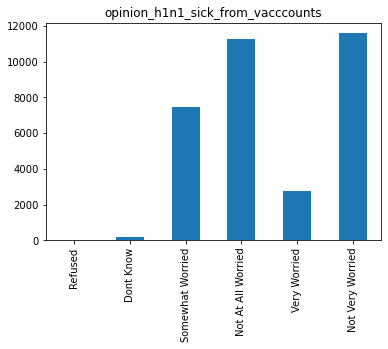

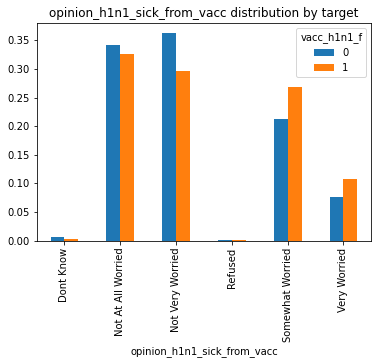

In [68]:
EDA_plot1(df,'opinion_h1n1_sick_from_vacc')

- Note : ordinal but category integration needed

In [69]:
type_feature['opinion_h1n1_sick_from_vacc'] = 'nominal'

##### opinion_seas_vacc_effective

- Description : Respondent's opinion about seasonal flu vaccine effectiveness.   

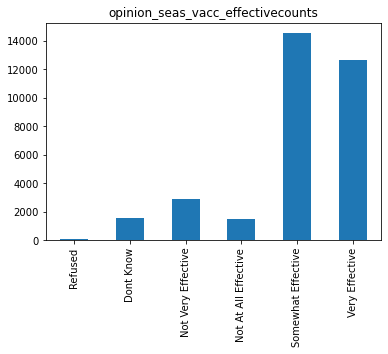

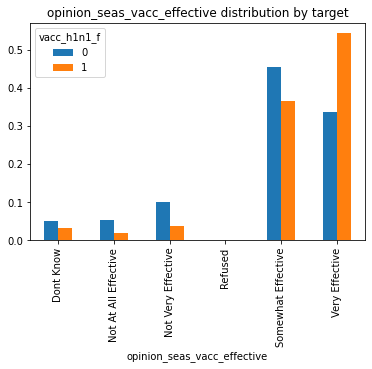

In [70]:
EDA_plot1(df,'opinion_seas_vacc_effective')

- Note : ordinal but category integration needed

In [71]:
type_feature['opinion_seas_vacc_effective'] = 'nominal'

##### opinion_seas_risk

- Description : Respondent's opinion about risk of getting sick with seasonal flu without vaccine.   

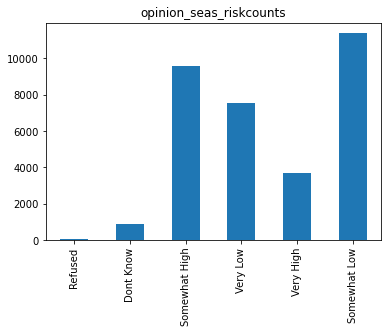

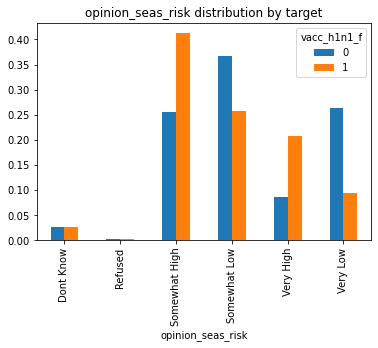

In [72]:
EDA_plot1(df,'opinion_seas_risk')

- Note : ordinal type, Don't Know/Refused -> 3, seasonal

In [73]:
type_feature['opinion_seas_risk'] = 'nominal' # change later

##### opinion_seas_sick_from_vacc

- Description : Respondent's worry of getting sick from taking seasonal flu vaccine.  

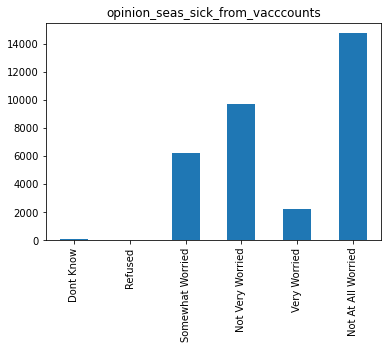

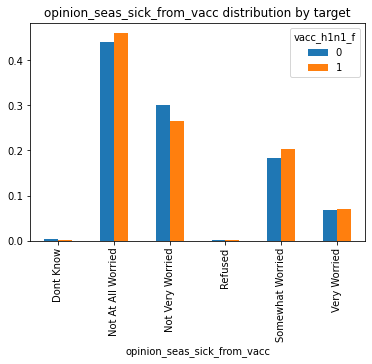

In [74]:
EDA_plot1(df,'opinion_seas_sick_from_vacc')

- Note : disorder, insignificant

In [75]:
type_feature['opinion_seas_sick_from_vacc'] = 'nominal'

##### agegrp

- Description : Age group of respondent.   

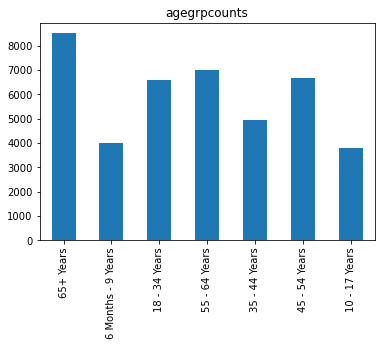

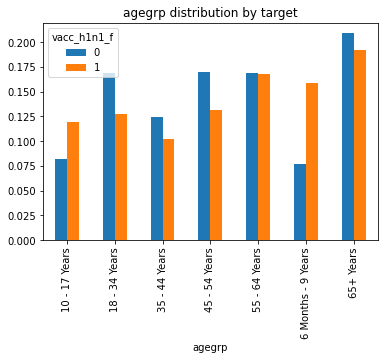

In [76]:
EDA_plot1(df,'agegrp')

- Note : ordinal type

In [77]:
df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
df['agegrp'].replace('10 - 17 Years',2,inplace=True)
df['agegrp'].replace('18 - 34 Years',3,inplace=True)
df['agegrp'].replace('35 - 44 Years',4,inplace=True)
df['agegrp'].replace('45 - 54 Years',5,inplace=True)
df['agegrp'].replace('55 - 64 Years',6,inplace=True)
df['agegrp'].replace('65+ Years',7,inplace=True)
type_feature['agegrp'] = 'ordinal'

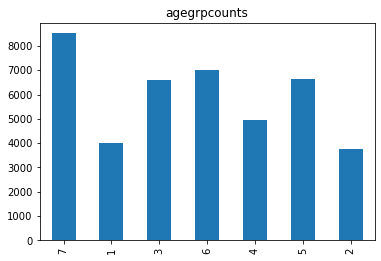

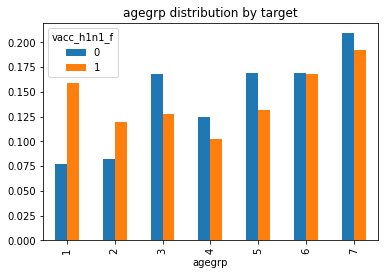

In [78]:
EDA_plot1(df,'agegrp')

- whether one is student or not is significant

##### education_comp

- Description : Self-reported education level.   
1 = < 12 Years; 2 = 12 Years; 3 = Some College; 4 = College Graduate   

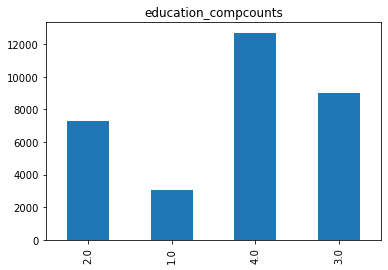

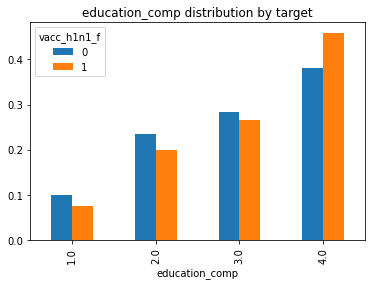

In [79]:
EDA_plot1(df,'education_comp')

- Note : disorder

In [80]:
type_feature['education_comp'] = 'nominal'

##### raceeth4_i

- Description : Race of respondent.   
1 = Hispanic; 2 = Non-Hispanic, Black Only; 3 = Non-Hispanic, White Only; 4 = Non-Hispanic, Other or Multiple Races   

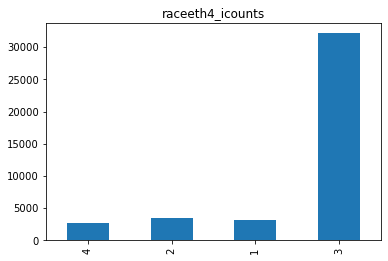

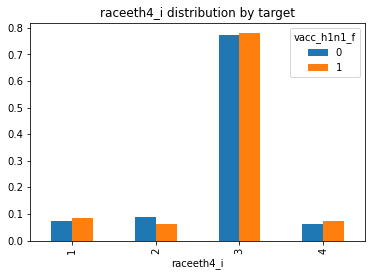

In [81]:
EDA_plot1(df,'raceeth4_i')

- Note : categorical type

In [82]:
df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
type_feature['raceeth4_i'] = 'nominal'

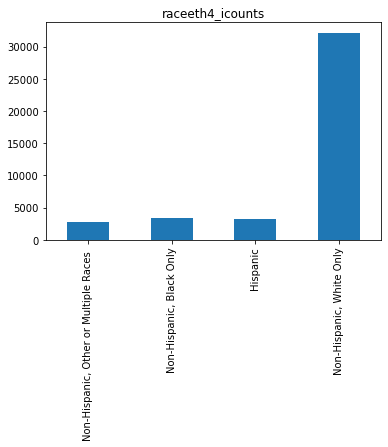

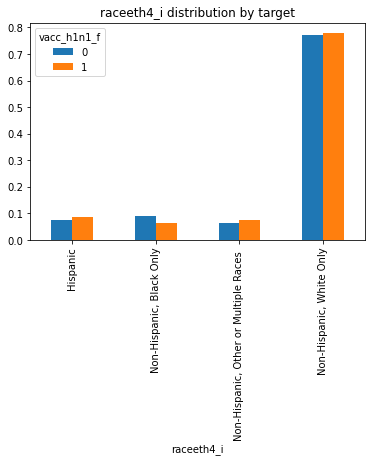

In [83]:
EDA_plot1(df,'raceeth4_i')

- Note : black or not

##### sex_i

- Description : Sex of respondent.   
1 = Male; 2 = Female   

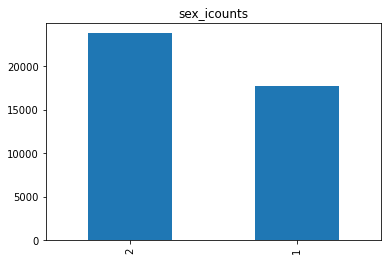

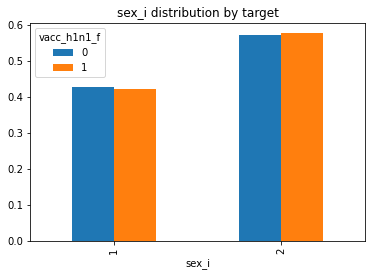

In [84]:
EDA_plot1(df,'sex_i')

- Note : boolean, Male=True, Female=False

In [85]:
df['sex_i'].replace(2,0,inplace=True)
type_feature['sex_i'] = 'bool'

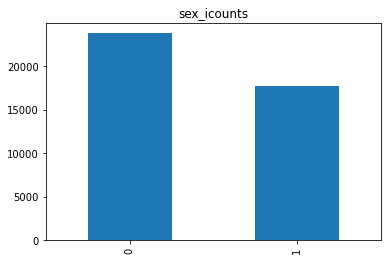

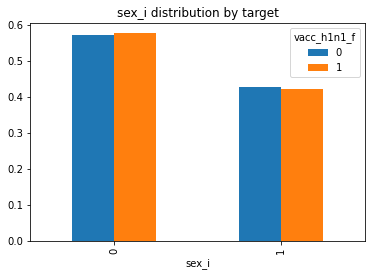

In [86]:
EDA_plot1(df,'sex_i')

- Note : insignificant

##### inc_pov

- Description : Household annual income of respondent with respect to 2008 Census poverty thresholds.   
1 : > $75,000; 2 : <= $75,000; 3 : Below Poverty; 4 : Unknown   

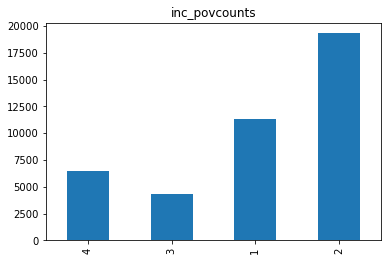

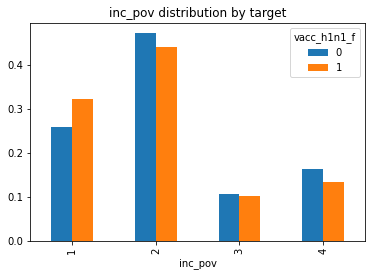

In [87]:
EDA_plot1(df,'inc_pov')

- Note : ordered categorical type, 4(Unknown) -> np.nan, 3(Below Poverty) -> 1, 1(>=$7500) -> 3

In [88]:
df['inc_pov'].replace(4,np.nan,inplace=True)
df['inc_pov'].replace(3,5,inplace=True)
df['inc_pov'].replace(1,3,inplace=True)
df['inc_pov'].replace(5,1,inplace=True)

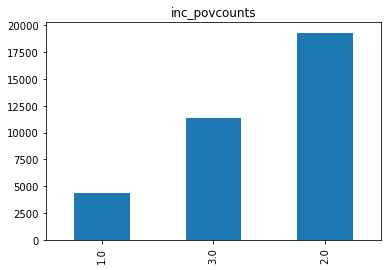

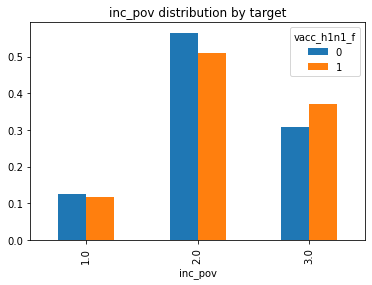

In [89]:
EDA_plot1(df,'inc_pov')

- Note : disorder

In [90]:
type_feature['inc_pov'] = 'nominal'

##### marital

- Description : Marital status of respondent.   
1 = Married; 2 = Not Married   

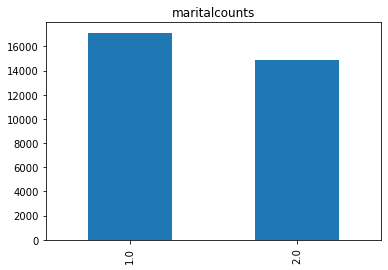

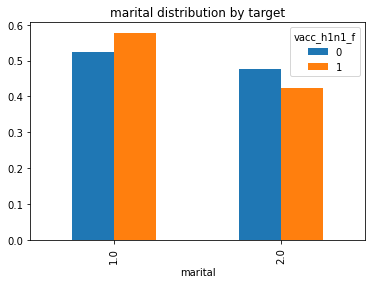

In [91]:
EDA_plot1(df,'marital')

- Note : boolean

In [92]:
df['marital'].replace(2,0,inplace=True)
type_feature['marital'] = 'bool'

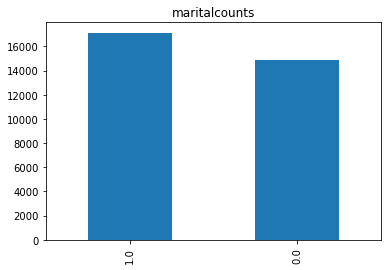

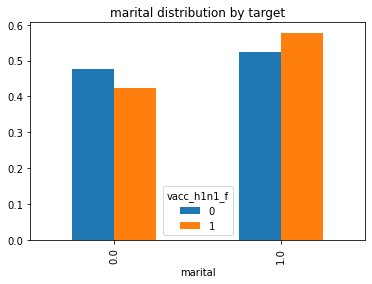

In [93]:
EDA_plot1(df,'marital')

##### rent_own_r

- Description : Housing situation of respondent.   
1 = Home is Owned; 2 = Home is Rented or Other Arrangement   

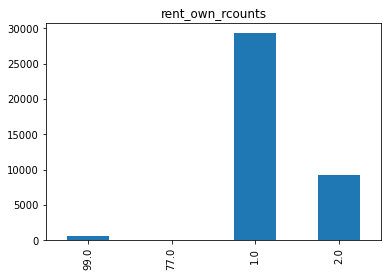

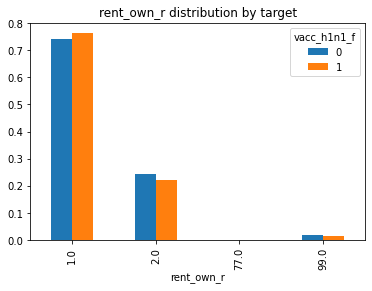

In [94]:
EDA_plot1(df,'rent_own_r')

- Note : boolean, Outliers(77,99 -> np.nan)

In [95]:
df['rent_own_r'].replace(77,np.nan,inplace=True)
df['rent_own_r'].replace(99,np.nan,inplace=True)
df['rent_own_r'].replace(2,0,inplace=True)
type_feature['rent_own_r'] = 'bool'

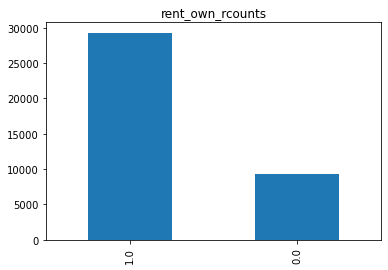

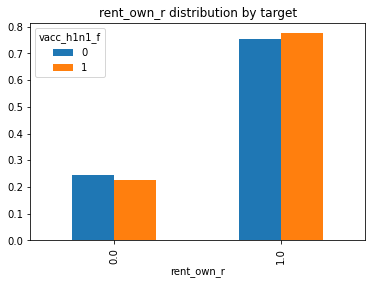

In [96]:
EDA_plot1(df,'rent_own_r')

##### employment_status

- Description : Employment status of respondent.   

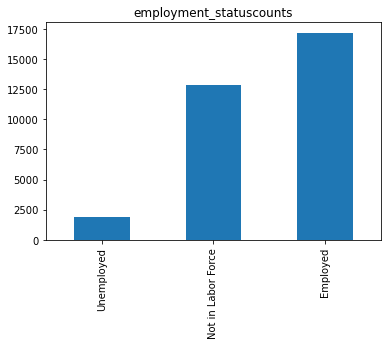

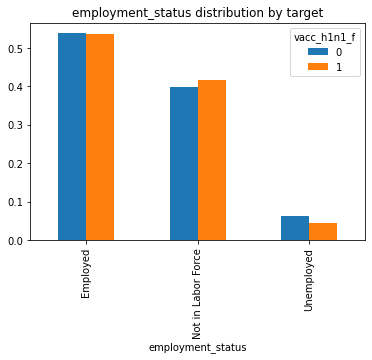

In [97]:
EDA_plot1(df,'employment_status')

- Note : disorder

In [98]:
type_feature['employment_status'] = 'nominal'

##### census_region

- Description : True census region of residence   
1=northeast; 2=midwest; 3=south; 4=west   

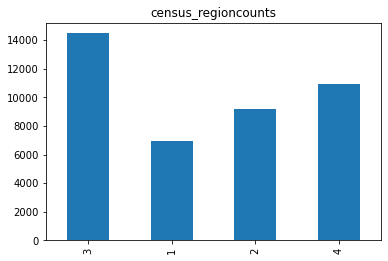

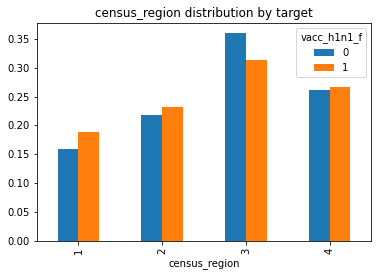

In [99]:
EDA_plot1(df,'census_region')

- Note : categorical type, location information

In [100]:
df['census_region'].replace(1,'northeast',inplace=True)
df['census_region'].replace(2,'midwest',inplace=True)
df['census_region'].replace(3,'south',inplace=True)
df['census_region'].replace(4,'west',inplace=True)
type_feature['census_region'] = 'nominal'

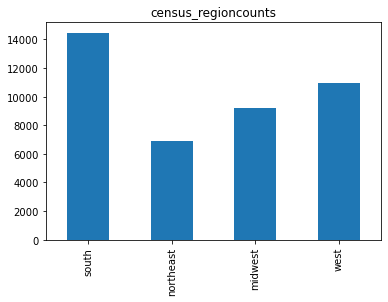

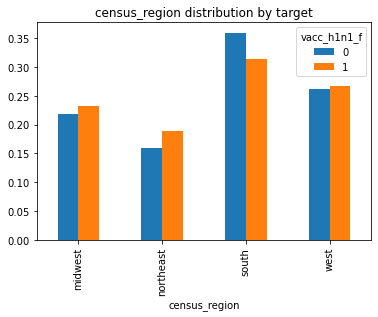

In [101]:
EDA_plot1(df,'census_region')

##### census_msa

- Description : Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.   

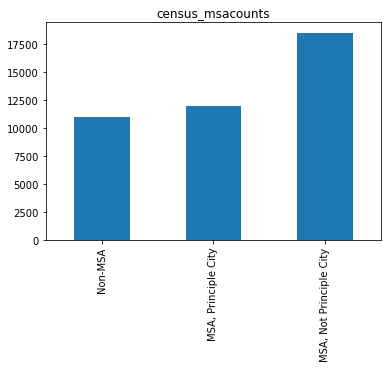

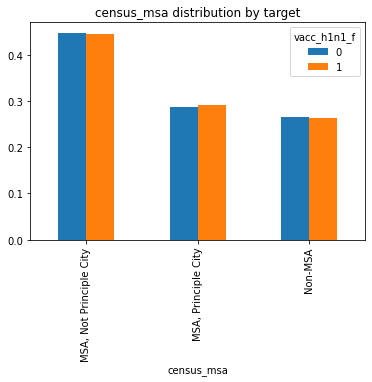

In [102]:
EDA_plot1(df,'census_msa')

- Note : ordered categorical type, location information

In [103]:
df['census_msa'].replace('Non-MSA',0,inplace=True)
df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
df['census_msa'].replace('MSA, Principle City',2,inplace=True)
type_feature['census_msa'] = 'ordinal'

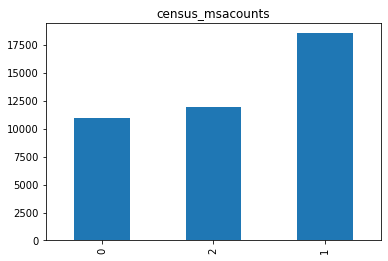

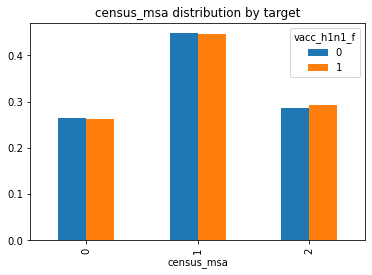

In [104]:
EDA_plot1(df,'census_msa')

##### n_adult_r

- Description : Number of other adults in household.   

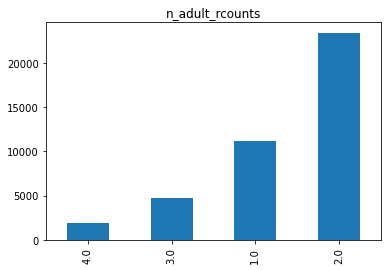

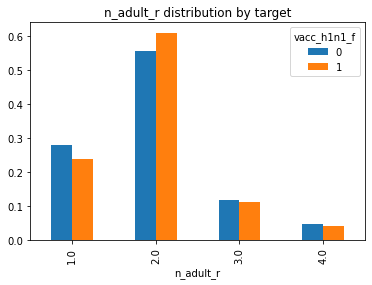

In [105]:
EDA_plot1(df,'n_adult_r')

- Note : ratio type

In [106]:
type_feature['n_adult_r'] = 'ratio'

##### household_children

- Description : Number of children in household.   

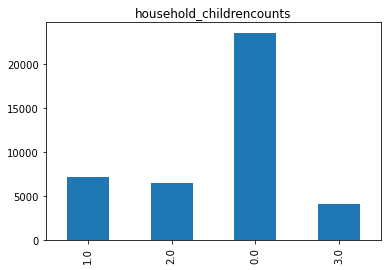

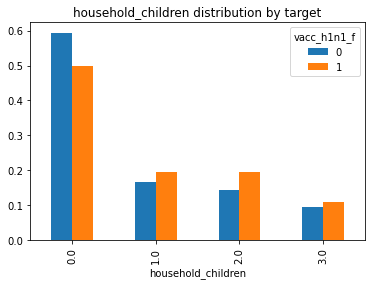

In [107]:
EDA_plot1(df,'household_children')

- Note : ratio type

In [108]:
type_feature['household_children'] = 'ratio'

##### n_people_r

- Description : Number of adults in the household.   

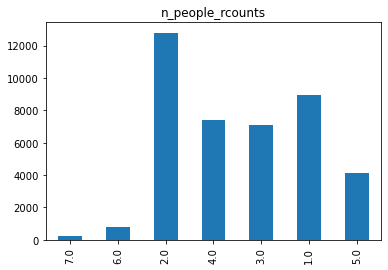

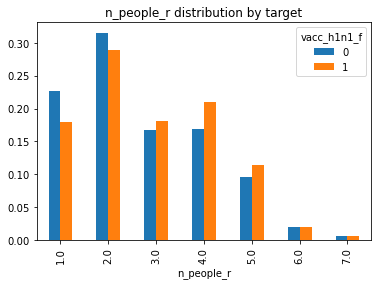

In [109]:
EDA_plot1(df,'n_people_r')

- Note : ratio type

In [110]:
type_feature['n_people_r'] = 'ratio'

##### employment_industry

- Description : Type of industry respondent is employed in.   

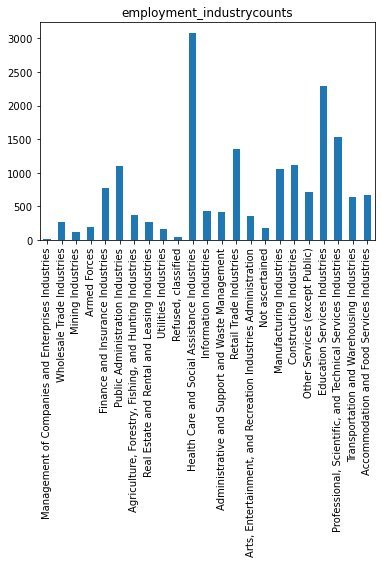

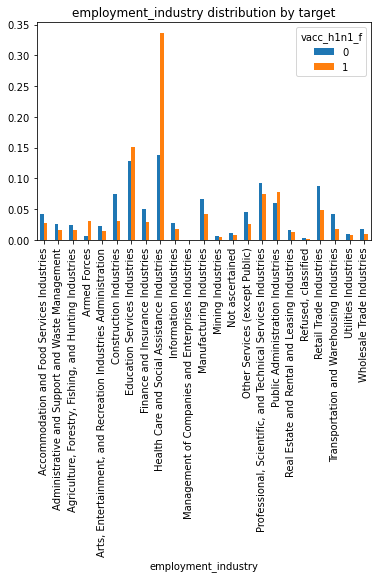

In [111]:
EDA_plot1(df,'employment_industry')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_occupation

In [112]:
df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_industry'] = 'nominal'

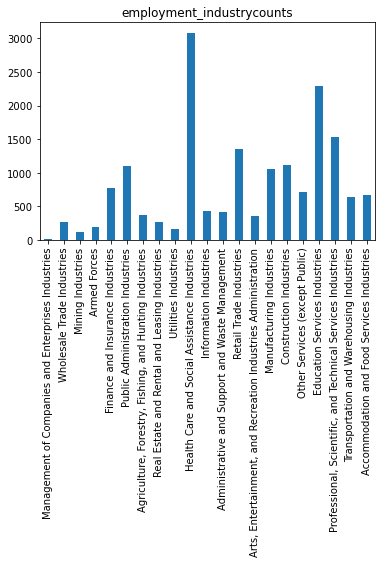

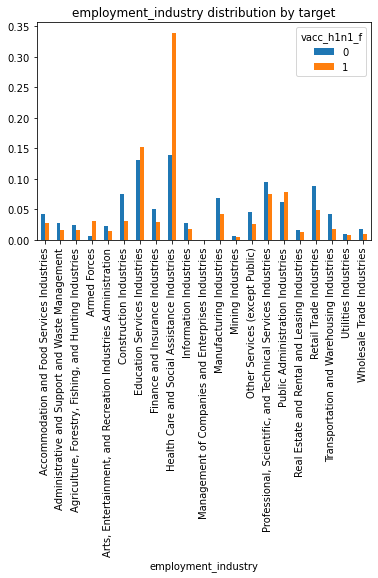

In [113]:
EDA_plot1(df,'employment_industry')

##### employment_occupation

- Description : Type of occupation of respondent. Values are represented as short random character strings.   

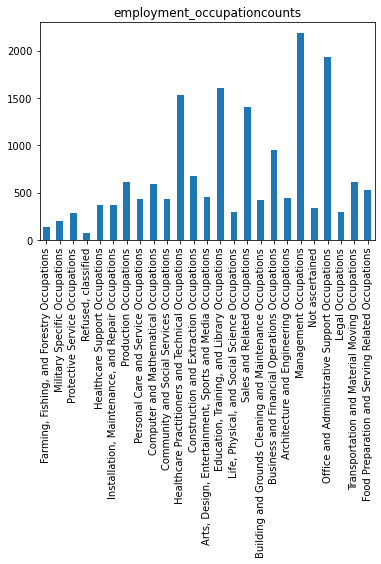

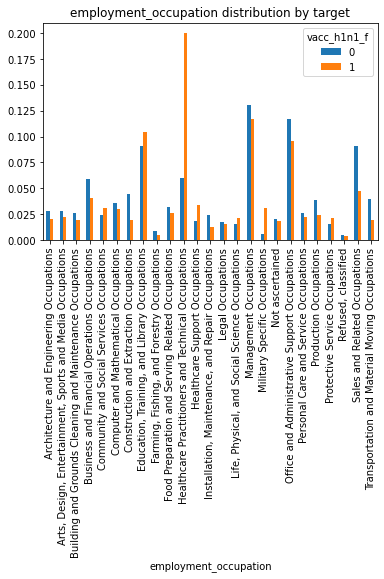

In [114]:
EDA_plot1(df,'employment_occupation')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_industry

In [115]:
df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_occupation'] = 'nominal'

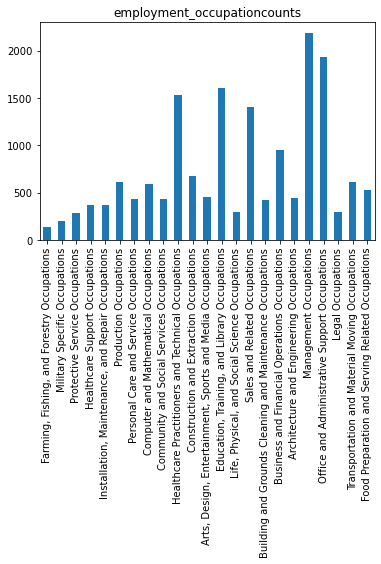

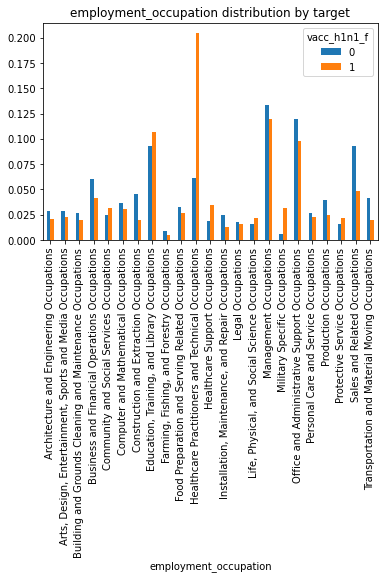

In [116]:
EDA_plot1(df,'employment_occupation')

##### hhs_region

- Description : HHS surveillance region number   
    - Region 1: CT,ME,MA,NH,RI,VT   
    - Region 2: NJ,NY   
    - Region 3: DE,DC,MD,PA,VA,WV   
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN   
    - Region 5: IL,IN,MI,MN,OH,WI   
    - Region 6: AR,LA,NM,OK,TX   
    - Region 7: IA,KS,MO,NE   
    - Region 8: CO,MT,ND,SD,UT,WY   
    - Region 9: AZ,CA,HI,NV   
    - Region 10: AK,ID,OR,WA   

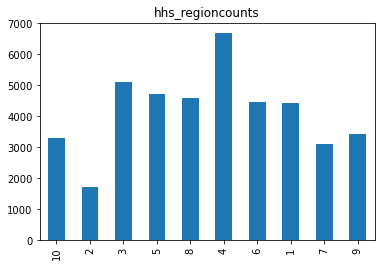

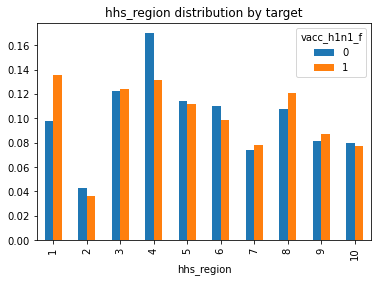

In [117]:
EDA_plot1(df,'hhs_region')

- Note : categorical type, location information, high cardinality

In [118]:
df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
type_feature['hhs_region'] = 'nominal'

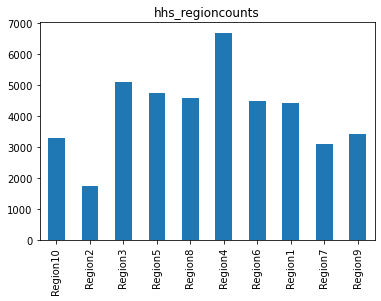

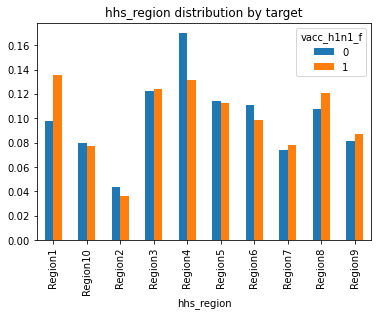

In [119]:
EDA_plot1(df,'hhs_region')

##### state

- Description : State of residence   

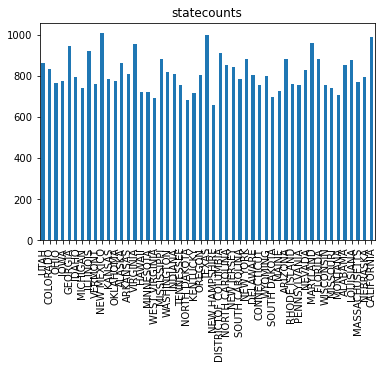

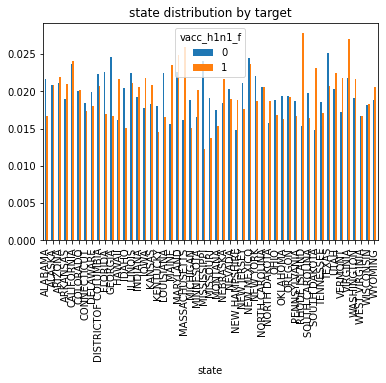

In [120]:
EDA_plot1(df,'state')

- Note : categorical type, local information, high cardinality

In [121]:
df['state'].replace('ALABAMA','AL',inplace=True)
df['state'].replace('ALASKA','AK',inplace=True)
df['state'].replace('ARIZONA','AZ',inplace=True)
df['state'].replace('ARKANSAS','AR',inplace=True)
df['state'].replace('CALIFORNIA','CA',inplace=True)
df['state'].replace('COLORADO','CO',inplace=True)
df['state'].replace('CONNECTICUT','CT',inplace=True)
df['state'].replace('DELAWARE','DE',inplace=True)
df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
df['state'].replace('FLORIDA','FL',inplace=True)
df['state'].replace('GEORGIA','GA',inplace=True)
df['state'].replace('HAWAII','HI',inplace=True)
df['state'].replace('IDAHO','ID',inplace=True)
df['state'].replace('ILLINOIS','IL',inplace=True)
df['state'].replace('INDIANA','IN',inplace=True)
df['state'].replace('IOWA','IA',inplace=True)
df['state'].replace('KANSAS','KS',inplace=True)
df['state'].replace('KENTUCKY','KY',inplace=True)
df['state'].replace('LOUISIANA','LA',inplace=True)
df['state'].replace('MAINE','ME',inplace=True)
df['state'].replace('MARYLAND','MD',inplace=True)
df['state'].replace('MASSACHUSETTS','MA',inplace=True)
df['state'].replace('MICHIGAN','MI',inplace=True)
df['state'].replace('MINNESOTA','MN',inplace=True)
df['state'].replace('MISSISSIPPI','MS',inplace=True)
df['state'].replace('MISSOURI','MO',inplace=True)
df['state'].replace('MONTANA','MT',inplace=True)
df['state'].replace('NEBRASKA','NE',inplace=True)
df['state'].replace('NEVADA','NV',inplace=True)
df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
df['state'].replace('NEW JERSEY','NJ',inplace=True)
df['state'].replace('NEW MEXICO','NM',inplace=True)
df['state'].replace('NEW YORK','NY',inplace=True)
df['state'].replace('NORTH CAROLINA','NC',inplace=True)
df['state'].replace('NORTH DAKOTA','ND',inplace=True)
df['state'].replace('OHIO','OH',inplace=True)
df['state'].replace('OKLAHOMA','OK',inplace=True)
df['state'].replace('OREGON','OR',inplace=True)
df['state'].replace('PENNSYLVANIA','PA',inplace=True)
df['state'].replace('RHODE ISLAND','RI',inplace=True)
df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
df['state'].replace('TENNESSEE','TN',inplace=True)
df['state'].replace('TEXAS','TX',inplace=True)
df['state'].replace('UTAH','UT',inplace=True)
df['state'].replace('VERMONT','VT',inplace=True)
df['state'].replace('VIRGINIA','VA',inplace=True)
df['state'].replace('WASHINGTON','WA',inplace=True)
df['state'].replace('WEST VIRGINIA','WV',inplace=True)
df['state'].replace('WISCONSIN','WI',inplace=True)
df['state'].replace('WYOMING','WY',inplace=True)
type_feature['state'] = 'nominal'

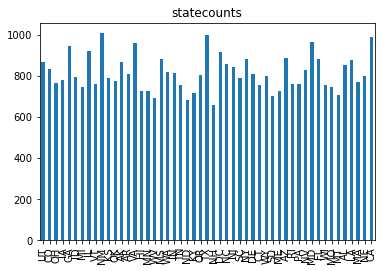

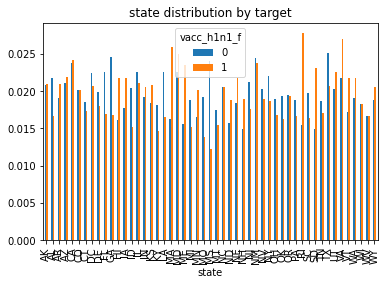

In [122]:
EDA_plot1(df,'state')

##### map visualization
feature : state, hhs_region, census_region

In [123]:
import json
import requests
from matplotlib.patches import Polygon
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
dc={"type":"Feature","id":"DC","properties":{"name":"District of Columbia"},"geometry":{"type":"Polygon","coordinates":[[[-77.040741, 38.791222],[-76.909294, 38.895284],[-77.035264, 38.993869],[-77.117418, 38.933623]]]}}
state_geo=dict(json.loads(requests.get(state_geo).text))['features']
state_geo.append(dc)

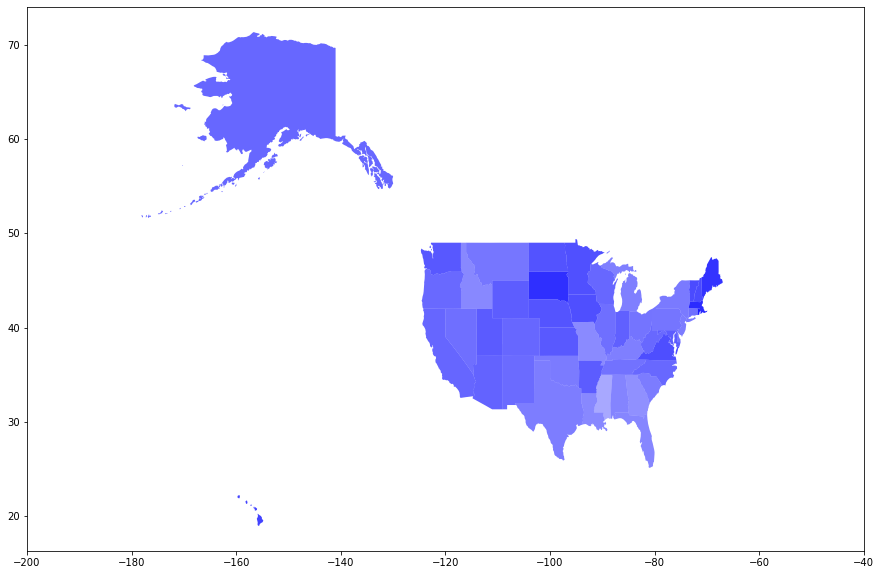

In [124]:
# vaccine rate group by state
vacc_rate_geo=df[['state','vacc_h1n1_f']].groupby(['state']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

In [125]:
# region relationships, census_msa can't be seperated by state
hhs={}
for i in range(10):
    hhs[f'Region{i+1}']=[]
census={
    'west':[],
    'midwest':[],
    'northeast':[],
    'south':[]
}
for s in df['state'].unique():
    hhs[df[df['state']==s]['hhs_region'].unique()[0]].append(s)
    census[df[df['state']==s]['census_region'].unique()[0]].append(s)
region_dict={}
for s in df['state'].unique():
    region_dict[s]=[df[df['state']==s]['hhs_region'].unique()[0],df[df['state']==s]['census_region'].unique()[0]]

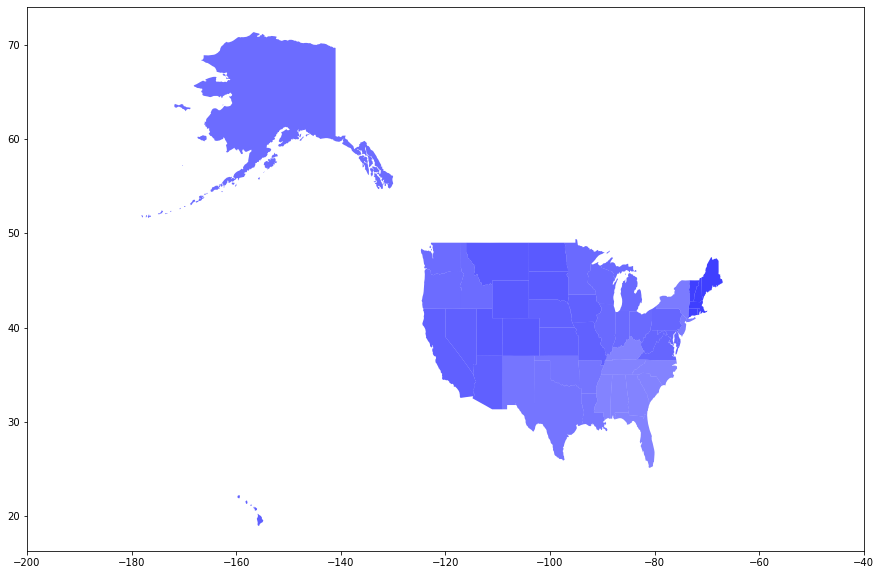

In [126]:
# vaccine rate group by hhs_region
vacc_rate_hhs=df[['hhs_region','vacc_h1n1_f']].groupby(['hhs_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

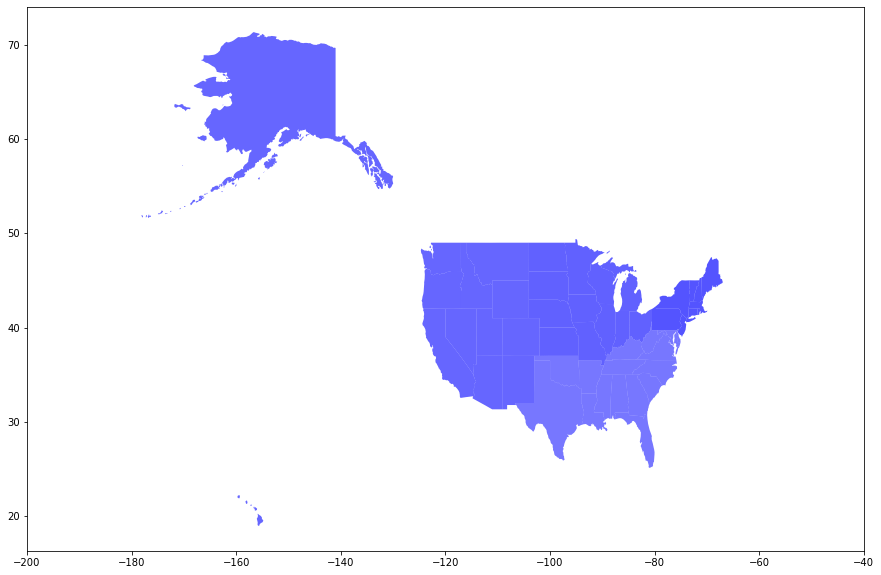

In [127]:
# vaccine rate group by census_region
vacc_rate_census=df[['census_region','vacc_h1n1_f']].groupby(['census_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

(state, hhs_region, census_region)x(vacc_h1n1_f, ...) more EDA probability

#### Multivariate analysis

##### Missing pattern and Structurally missing data

In [128]:
#dummy variable of missing values
df_MV=df[:].isna()
df_MV.columns = map(lambda x: x+'_mv',df.columns)
df_MV=df_MV[df_MV.columns[df_MV.sum().map(bool).tolist()]]
df_MV.head()

,h1n1_concern_mv,h1n1_knowledge_mv,behavioral_antiviral_meds_mv,behavioral_avoidance_mv,behavioral_face_mask_mv,behavioral_wash_hands_mv,behavioral_large_gatherings_mv,behavioral_outside_home_mv,behavioral_touch_face_mv,doctor_recc_h1n1_mv,...,education_comp_mv,inc_pov_mv,marital_mv,rent_own_r_mv,employment_status_mv,n_adult_r_mv,household_children_mv,n_people_r_mv,employment_industry_mv,employment_occupation_mv
0,True,True,True,True,True,True,True,True,True,False,...,True,False,True,False,True,False,False,False,True,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

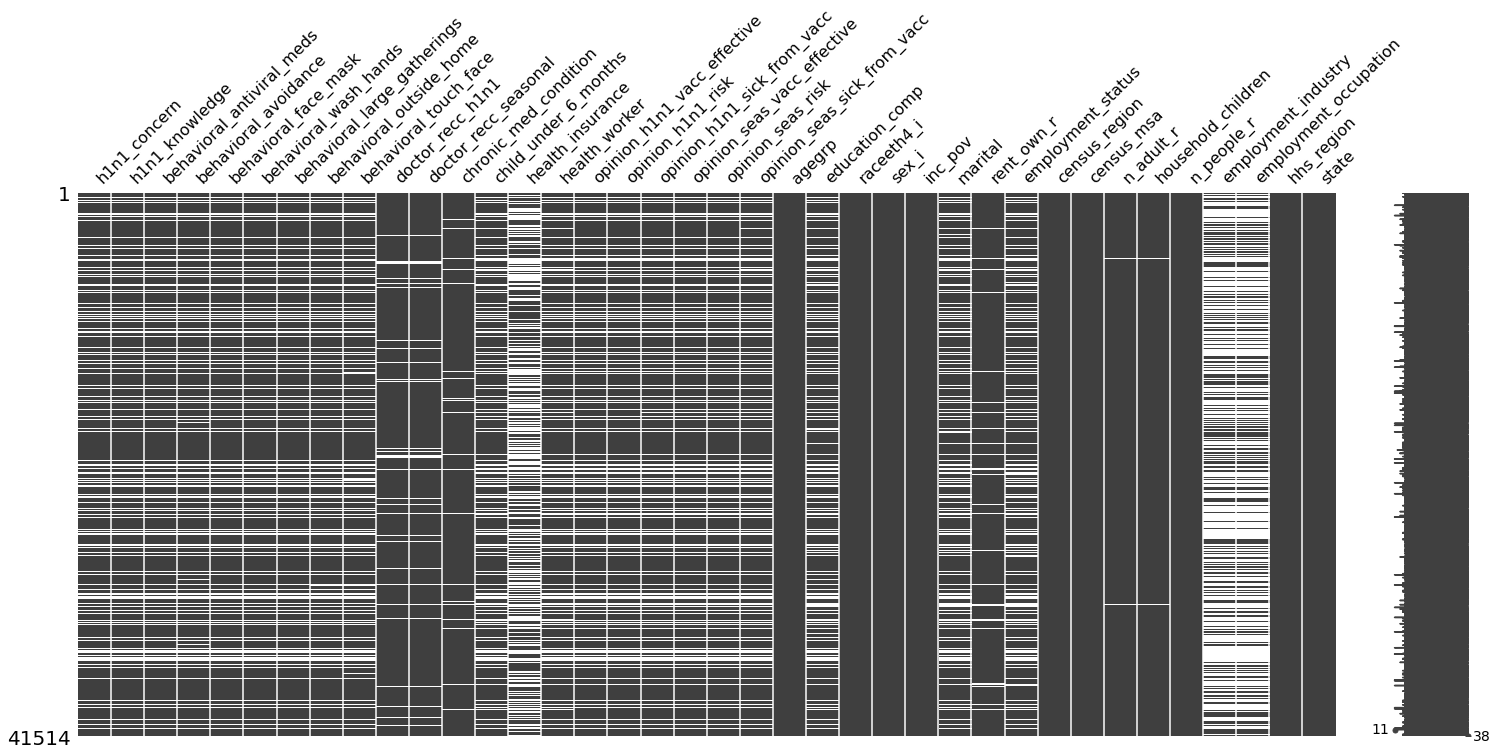

In [129]:
msno.matrix(train)

<AxesSubplot:>

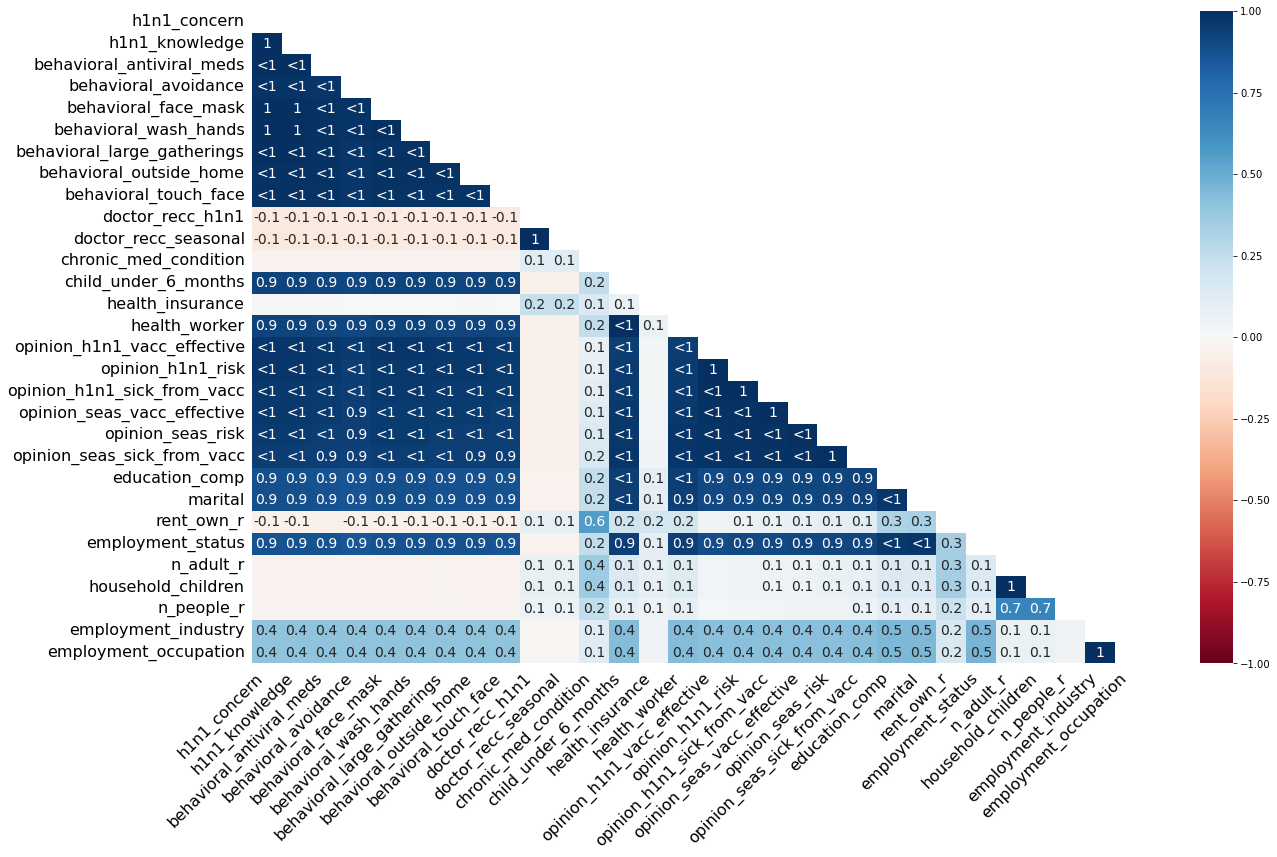

In [130]:
msno.heatmap(train)

- Missing patterns   
    - pattern_A
        - h1n1_concern
        - h1n1_knowledge
        - behavioral_antiviral_meds
        - behavioral_avoidance
        - behavioral_face_mask
        - behavioral_wash_hands
        - behavioral_large_gatherings
        - behavioral_outside_home
        - behavioral_touch_face
        - child_under_6_months
        - health_worker
        - opinion_h1n1_vacc_effective *
        - opinion_h1n1_risk
        - opinion_h1n1_sick_from_vacc
        - opinion_seas_vacc_effective
        - opinion_seas_risk
        - opinion_seas_sick_from_vacc
        - education_comp
        - marital
        - employment_status
    - pattern_B
        - doctor_recc_h1n1
        - doctor_recc_seasonal
    - pattern_C
        - n_adult_r
        - househole_children
        - n_people_r
    - pattern_D
        - employment_industry
        - employment_occupation

- response rate

In [131]:
unresponse=df_MV.sum(axis=1)

<AxesSubplot:>

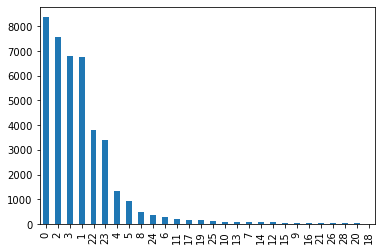

In [132]:
unresponse.value_counts().plot(kind='bar')

In [133]:
unresponse = unresponse.map(lambda x: x if x in [0,2,3,1,22,23] else 99)

- Structurally missing data

In [134]:
#corr 직접 구해야함. corr()메소드는 50개만 구함, 이거따로 바로 위로올라갈지도
df_MV_corr=pd.concat([df,df_MV],axis=1)
df.shape, df_MV.shape, df_MV_corr.shape
#이 방법 말고 structurely missing data 검출가능한가?
# smd는 특정 카테고리가 특정 feature에서 전부 nan값이 떠야함 아니면 대부분?
# 즉 특정 카테고리가 특정 feature에서 전부 nan이 뜨는 경우들 중 smd가 있음.

((41514, 40), (41514, 31), (41514, 71))

In [135]:
#agegrp에 하기전에 무직 Null값채우기 해야함. 개별분석에서 agegrp이랑 겹치는줄알고 지움
df[df['employment_status']=='Unemployed']['employment_industry'].value_counts()

Series([], Name: employment_industry, dtype: int64)

Filling some MVs with age_group
- 1: '6 Months - 9 Years'
- 2: '10 - 17 Years'
- 3: '18 - 34 Years'
- 4: '35 - 44 Years'
- 5: '45 - 54 Years'
- 6: '55 - 64 Years'
- 7: '65+ Years'


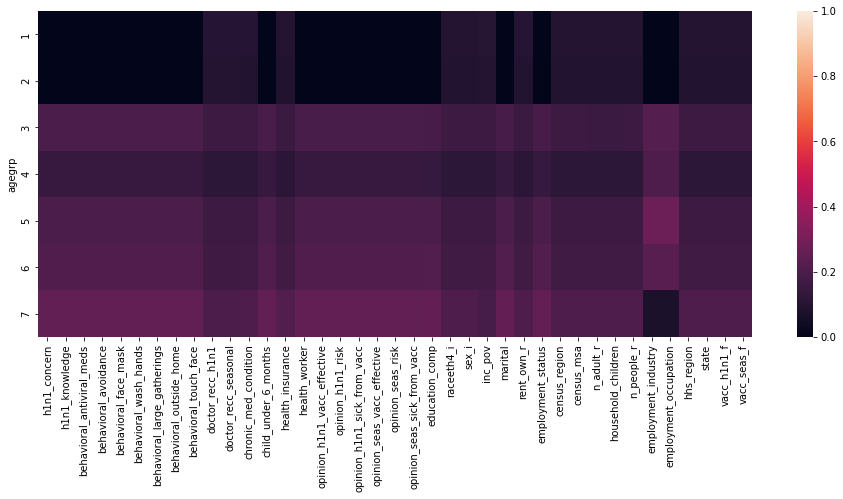

In [136]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)


In [137]:
#1,2,7그룹으로 결측치 채우기
df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
df['marital']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['marital'],axis=1)
df['employment_status']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
df['employment_status']=df.apply(lambda x: 'Unemployed' if x['agegrp'] == 7 else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)


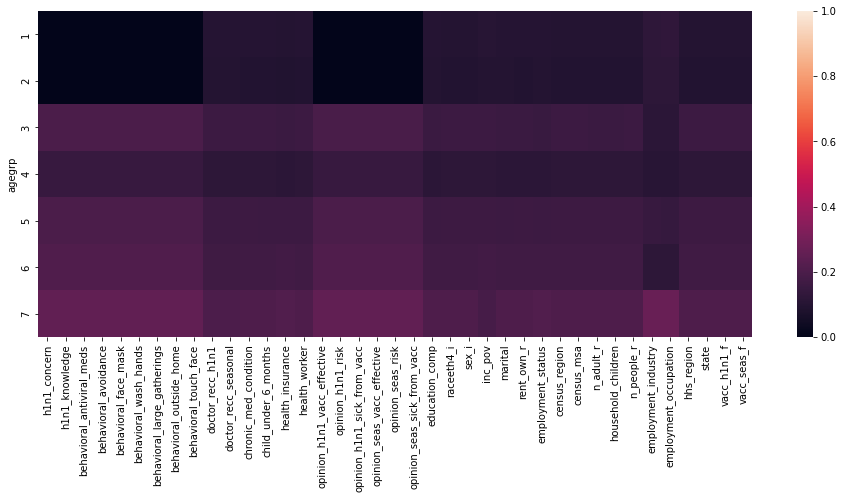

In [138]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)

<AxesSubplot:>

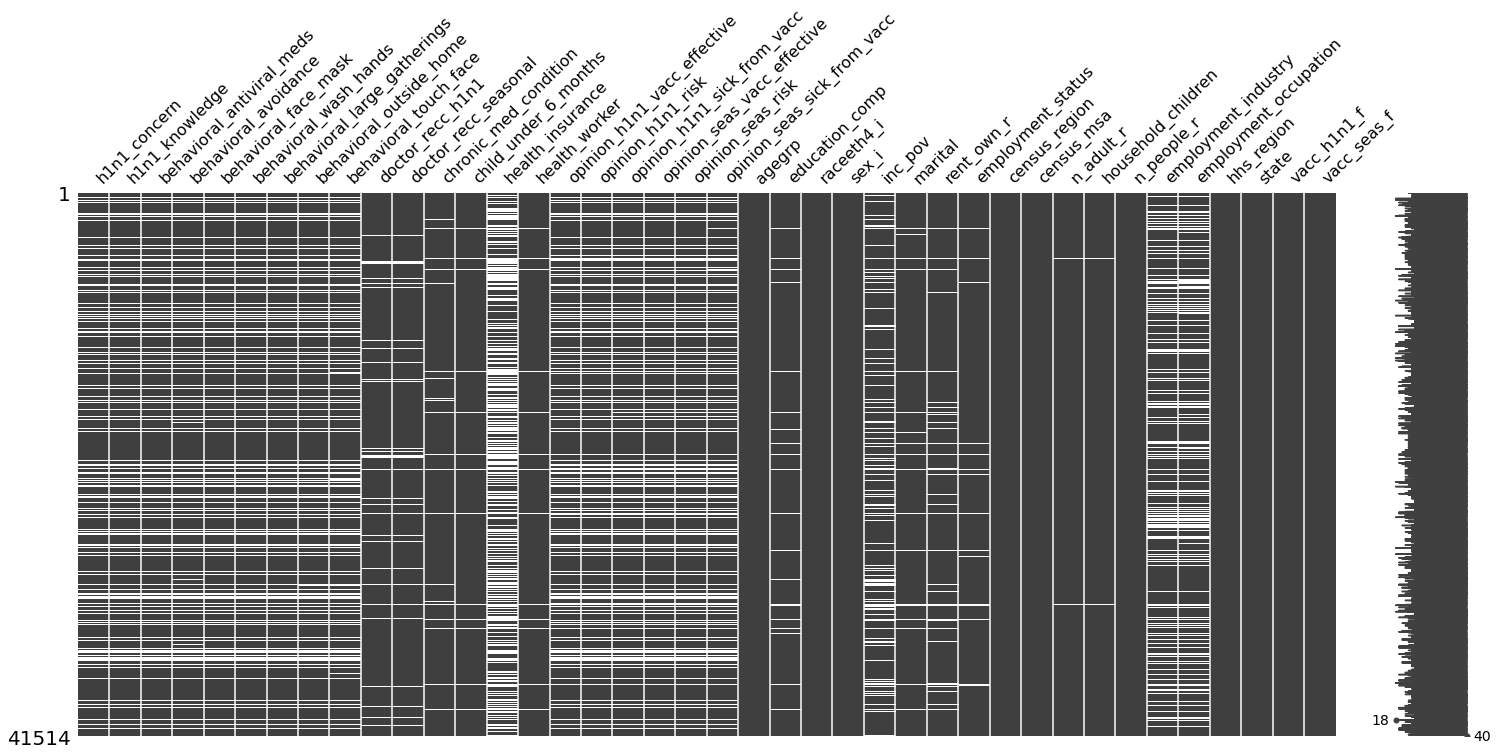

In [139]:
msno.matrix(df)

In [140]:
# n_people_r = n_adult_r + household_children
for i in range(len(df)):
    pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
    if np.isnan(pList).sum()==1:
        if np.isnan(pList[0]):
            df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
        elif np.isnan(pList[1]):
            df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
        else:
            df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
            

MCAR

In [141]:
# feature - MV_dummy_feature chi2 test
# H0 : they are independent.
# Ha : they are not independent.
# p<0.05 : dismiss H0 and select Ha.
# p>0.05 : don't know.
# p<0.05 for at least 1 featrue : It is related to some features so it is not MCAR.
# p>0.05 for all features : It can be MCAR. more analysis needed. store at suspect.
suspect=[]
for i in df_MV.columns:
    molu=True
    if df_MV[i].sum()==0:
        print(f'there is no MV in {i}')
        continue
    for j in df.columns:
        obs=pd.crosstab(df_MV[i],df[j])
        p=scipy.stats.chi2_contingency(obs)[1]
        if p<0.05 :
            print(f'{i} is not MCAR')
            molu=False
            break
    if molu:
        print(f'{i} can be MCAR')
        suspect.append(i)


h1n1_concern_mv is not MCAR
h1n1_knowledge_mv is not MCAR
behavioral_antiviral_meds_mv is not MCAR
behavioral_avoidance_mv is not MCAR
behavioral_face_mask_mv is not MCAR
behavioral_wash_hands_mv is not MCAR
behavioral_large_gatherings_mv is not MCAR
behavioral_outside_home_mv is not MCAR
behavioral_touch_face_mv is not MCAR
doctor_recc_h1n1_mv is not MCAR
doctor_recc_seasonal_mv is not MCAR
chronic_med_condition_mv is not MCAR
child_under_6_months_mv is not MCAR
health_insurance_mv is not MCAR
health_worker_mv is not MCAR
opinion_h1n1_vacc_effective_mv is not MCAR
opinion_h1n1_risk_mv is not MCAR
opinion_h1n1_sick_from_vacc_mv is not MCAR
opinion_seas_vacc_effective_mv is not MCAR
opinion_seas_risk_mv is not MCAR
opinion_seas_sick_from_vacc_mv is not MCAR
education_comp_mv is not MCAR
inc_pov_mv is not MCAR
marital_mv is not MCAR
rent_own_r_mv is not MCAR
employment_status_mv is not MCAR
n_adult_r_mv is not MCAR
household_children_mv is not MCAR
n_people_r_mv is not MCAR
employment_in

In [142]:
print(suspect)

[]


##### Test of Independence

In [143]:
# nominal-nominal : chi2 and fisher
# bool-ordinal : Mann Whitney U test groupby bool
# nominal-ordinal : Kruskal–Wallis groupby nominal
# ordinal-ordinal : Mann Whitney U test

for i in itertools.combinations(df.columns,2):
    if not set(i)-set(('nominal','bool')):
        obs=pd.crosstab(df[i[0]],df[i[1]])
        obsl=list(itertools.chain.from_iterable(np.array(obs)))
        l=len(obsl)
        a=len(list(itertools.filterfalse(lambda x: x<5,map(lambda x: x[0]*x[1]/sum(obsl),itertools.permutations(obsl,2)))))
        if a<l/5: # fisher
            if l==4:
                p=scipy.stats.fisher_exact(obs)
                if p<0.05:
                    print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
        else: # chi2
            p=scipy.stats.chi2_contingency(obs,correction=False)[1]
            if p<0.05:
                print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')

    elif not set(i)-set(('ordinal','interval')): # 
        p=scipy.stats.mannwhitneyu(i[0],i[1])
        if p[1]<0.05:
            print(i[0],i[1],p)
    elif set(i)==set(('bool','interval')) or set(i)==set(('bool','ordinal')):
        if i[0]=='bool':
            a=df[df[i[0]]==1]
            b=df[df[i[0]]==0]
        else:
            a=df[df[i[1]]==1]
            b=df[df[i[1]]==0]
        p=scipy.stats.mannwhitneyu(a,b)
        if p[1]<0.05:
            print(i[0],i[1],p)
    else:
        catlist=[]
        if i[0]=='nominal':
            for cat in df[i[0]].unique():
                catlist.append(df[df[i[0]]==cat][i[1]])
        else:
            for cat in df[i[1]].unique():
                catlist.append(df[df[i[1]]==cat][i[0]])
        p=scipy.stats.kruskal(*catlist)
        if p[1]<0.05:
            print(i[0],i[1],p)

agegrp raceeth4_i KruskalResult(statistic=1712.5512905965722, pvalue=0.0)
agegrp sex_i KruskalResult(statistic=375.20895373700347, pvalue=1.3742461197643081e-83)
agegrp census_region KruskalResult(statistic=26.165995728675643, pvalue=8.803823338120655e-06)
agegrp census_msa KruskalResult(statistic=118.9279330082987, pvalue=1.496674899268618e-26)
agegrp hhs_region KruskalResult(statistic=29.11160896836757, pvalue=0.0006205382585624457)
agegrp state KruskalResult(statistic=237.82384623790026, pvalue=2.928803581924807e-26)
agegrp vacc_h1n1_f KruskalResult(statistic=205.4041017667274, pvalue=1.3823318715982148e-46)
agegrp vacc_seas_f KruskalResult(statistic=1604.978142934509, pvalue=0.0)
raceeth4_i sex_i KruskalResult(statistic=16.315295695615948, pvalue=5.3629317094093134e-05)
raceeth4_i census_region KruskalResult(statistic=867.1773909165554, pvalue=1.164973729494628e-187)
raceeth4_i census_msa KruskalResult(statistic=903.3405873388914, pvalue=6.951584716735408e-197)
raceeth4_i hhs_regio

##### Correlation

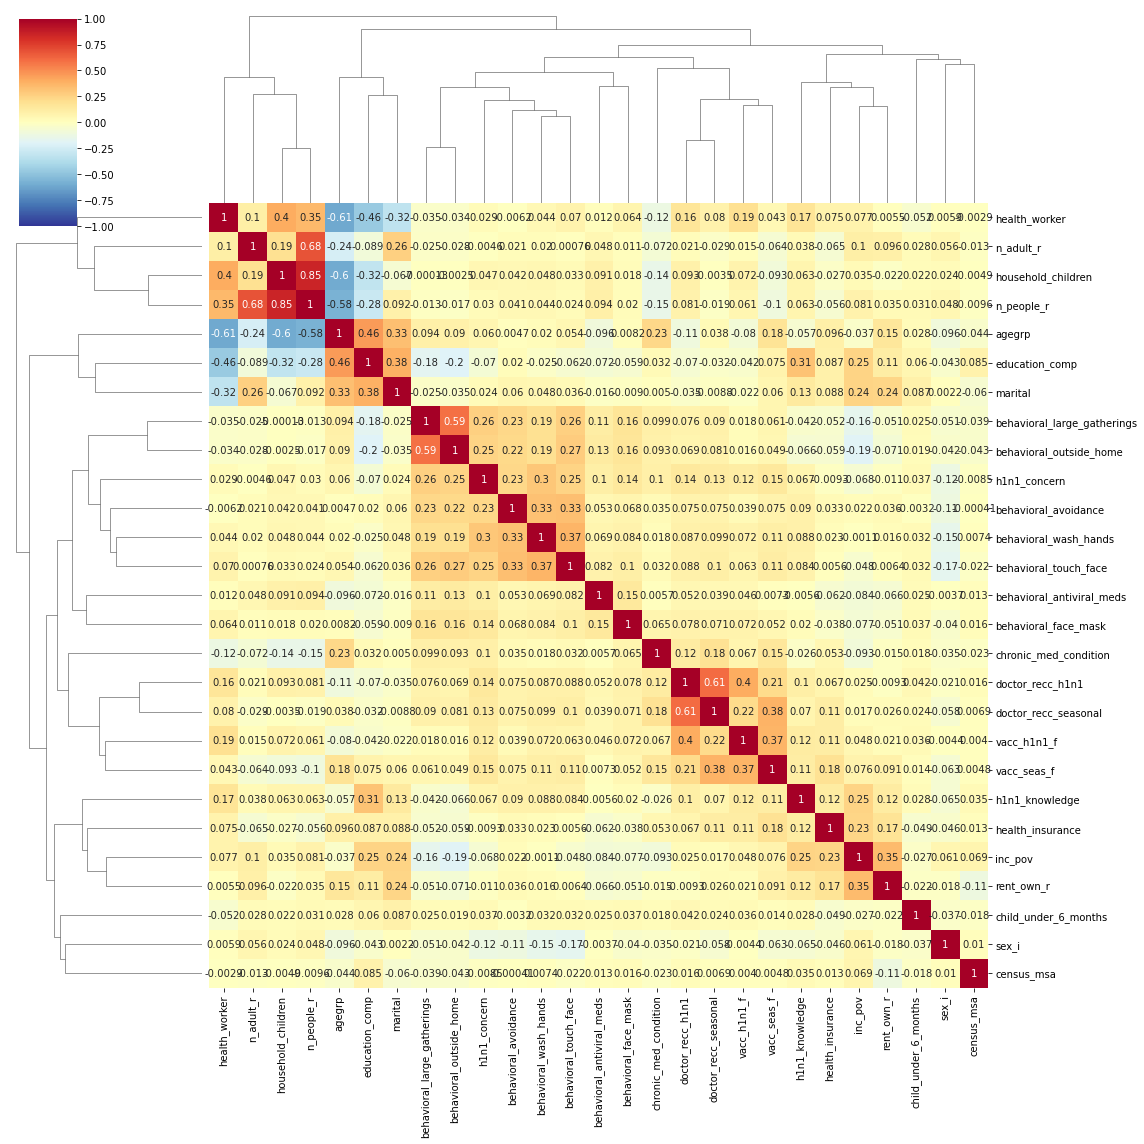

In [144]:
corr = df.corr(method='pearson')
sns.clustermap(corr, 
            annot = True,      # 실제 값 화면에 나타내기
            cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
            vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
            figsize=(16,16)
            )

Note : household_children, n_people_r are correlated but

In [145]:
# n_adult_r + household_children = n_people_r
for i in range(len(df)):
    if np.isnan(df['n_adult_r'][i]) or np.isnan(df['household_children'][i]) or np.isnan(df['n_people_r'][i]):
        continue
    if df['n_adult_r'][i]+df['household_children'][i]!=df['n_people_r'][i]:
        print(f"{df['n_adult_r'][i]},{df['household_children'][i]},{df['n_people_r'][i]}")

##### Clustering

In [146]:
!pip install kpod

In [147]:
# one-hot encoder
def encoder(df,type_feature_temp):
    encode_needed = [x for x in df.columns if type_feature_temp[x]=='nominal']
    encoded = pd.get_dummies(df,columns=encode_needed)
    col_list = encoded.columns.tolist()
    for i in range(len(col_list)):
        col_list[i] = col_list[i].replace(',','_')
        col_list[i] = col_list[i].replace(' ','_')
    encoded.columns = col_list
    return encoded

In [148]:
from sklearn.metrics.pairwise import pairwise_distances

# X shoudl be a numpy matrix, very likely sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix
# T1 > T2 for overlapping clusters
# T1 = Distance to centroid point to not include in other clusters
# T2 = Distance to centroid point to include in cluster
# T1 > T2 for overlapping clusters
# T1 < T2 will have points which reside in no clusters
# T1 == T2 will cause all points to reside in mutually exclusive clusters
# Distance metric can be any from here: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html
# filemap may be a list of point names in their order in X. If included, row numbers from X will be replaced with names from filemap. 
 
def canopy(X, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

In [149]:
cnp=canopy(encoder(df[train.columns].dropna(),type_feature),7,4)
print(len(cnp))
print(cnp)

7
{0: {'c': 0, 'points': [0]}, 1: {'c': 2, 'points': [2, 1853, 2603, 3204, 5122, 5216, 6261, 6535, 7087, 7340, 7719, 8006, 8719, 9142, 10605, 10612, 10890, 11108, 11206]}, 2: {'c': 9216, 'points': [9216]}, 3: {'c': 4608, 'points': [1441, 1640, 1649, 2473, 3075, 3410, 4608, 4792, 5655, 5883, 6571, 7158, 8271, 8456, 9208, 9506, 9574, 9790, 10436, 10770]}, 4: {'c': 7808, 'points': [943, 7808]}, 5: {'c': 2624, 'points': [2624]}, 6: {'c': 6352, 'points': [6352]}}


In [150]:
# import the k_pod method
from kPOD import k_pod

# set the number of clusters desired (in this example, 3)
K = 7

# use previously existing data to perform clustering
clustering_results = k_pod(encoder(df[train.columns],type_feature), K)

# k_pod outputs a tuple with the cluster assignments and centers
print(clustering_results)


# save the cluster assignments and centers
cluster_assignments = clustering_results[0]
cluster_centers = clustering_results[1]

(array([1., 0., 3., ..., 5., 4., 6.]), [array([1.65830996e+00, 3.07995861e-02, 7.22504362e-01, 6.73757501e-02,
       8.23059713e-01, 3.96499807e-01, 3.77441395e-01, 6.90959576e-01,
       2.11185295e-01, 3.76243970e-01, 3.58841557e-01, 6.19610393e-02,
       7.74263133e-01, 8.38733504e-02, 6.26905096e+00, 3.83648901e-01,
       4.55095987e-01, 8.03105663e-01, 9.75338943e-01, 1.53889117e+00,
       2.02407225e-02, 1.55931672e+00, 1.22662459e-01, 5.45348294e-01,
       3.31989247e-01, 2.14936886e-01, 3.10308555e-02, 5.91982235e-02,
       3.91538102e-03, 4.07141187e-01, 2.75303880e-01, 6.03085554e-02,
       3.09724170e-03, 1.84373539e-01, 3.51273960e-01, 5.24777934e-02,
       3.38884993e-01, 9.29172511e-03, 3.55014025e-01, 3.40521272e-01,
       1.46096307e-03, 2.10787751e-01, 7.18793829e-02, 5.93151005e-02,
       3.96797569e-02, 6.66783544e-02, 2.68817204e-03, 3.83239832e-01,
       4.35717625e-01, 3.78681627e-02, 2.57129500e-03, 2.91841982e-01,
       3.11360449e-01, 1.07585320e-01

In [151]:
(len(df), len(clustering_results[0]))

(41514, 41514)

In [152]:
# Cluster sampling
split_index = pd.DataFrame(clustering_results[0],columns=['cluster']).reset_index()
train_index = []
test_index = []
validate_index = []
for i in split_index.cluster.unique():
    X_temp,X_test,y_temp,y_test = train_test_split(split_index[split_index.cluster==i],split_index[split_index.cluster==i],test_size=0.2,random_state=42)
    X_train,X_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size=0.2,random_state=42)
    train_index.extend(X_train.index.tolist())
    test_index.extend(X_test.index.tolist())
    validate_index.extend(X_val.index.tolist())
len(train_index), len(test_index), len(validate_index)

(26563, 8306, 6645)

##### Factor analysis

In [153]:
# skip

##### Functionization

In [154]:
def EDA(df):
    df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
    df['agegrp'].replace('10 - 17 Years',2,inplace=True)
    df['agegrp'].replace('18 - 34 Years',3,inplace=True)
    df['agegrp'].replace('35 - 44 Years',4,inplace=True)
    df['agegrp'].replace('45 - 54 Years',5,inplace=True)
    df['agegrp'].replace('55 - 64 Years',6,inplace=True)
    df['agegrp'].replace('65+ Years',7,inplace=True)
    df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
    df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
    df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
    df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
    df['sex_i'].replace(2,0,inplace=True)
    df['inc_pov'].replace(4,np.nan,inplace=True)
    df['inc_pov'].replace(3,5,inplace=True)
    df['inc_pov'].replace(1,3,inplace=True)
    df['inc_pov'].replace(5,1,inplace=True)
    df['marital'].replace(2,0,inplace=True)
    df['rent_own_r'].replace(77,np.nan,inplace=True)
    df['rent_own_r'].replace(99,np.nan,inplace=True)
    df['rent_own_r'].replace(2,0,inplace=True)
    df['census_region'].replace(1,'northeast',inplace=True)
    df['census_region'].replace(2,'midwest',inplace=True)
    df['census_region'].replace(3,'south',inplace=True)
    df['census_region'].replace(4,'west',inplace=True)
    df['census_msa'].replace('Non-MSA',0,inplace=True)
    df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
    df['census_msa'].replace('MSA, Principle City',2,inplace=True)
    df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
    df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
    df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
    df['state'].replace('ALABAMA','AL',inplace=True)
    df['state'].replace('ALASKA','AK',inplace=True)
    df['state'].replace('ARIZONA','AZ',inplace=True)
    df['state'].replace('ARKANSAS','AR',inplace=True)
    df['state'].replace('CALIFORNIA','CA',inplace=True)
    df['state'].replace('COLORADO','CO',inplace=True)
    df['state'].replace('CONNECTICUT','CT',inplace=True)
    df['state'].replace('DELAWARE','DE',inplace=True)
    df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
    df['state'].replace('FLORIDA','FL',inplace=True)
    df['state'].replace('GEORGIA','GA',inplace=True)
    df['state'].replace('HAWAII','HI',inplace=True)
    df['state'].replace('IDAHO','ID',inplace=True)
    df['state'].replace('ILLINOIS','IL',inplace=True)
    df['state'].replace('INDIANA','IN',inplace=True)
    df['state'].replace('IOWA','IA',inplace=True)
    df['state'].replace('KANSAS','KS',inplace=True)
    df['state'].replace('KENTUCKY','KY',inplace=True)
    df['state'].replace('LOUISIANA','LA',inplace=True)
    df['state'].replace('MAINE','ME',inplace=True)
    df['state'].replace('MARYLAND','MD',inplace=True)
    df['state'].replace('MASSACHUSETTS','MA',inplace=True)
    df['state'].replace('MICHIGAN','MI',inplace=True)
    df['state'].replace('MINNESOTA','MN',inplace=True)
    df['state'].replace('MISSISSIPPI','MS',inplace=True)
    df['state'].replace('MISSOURI','MO',inplace=True)
    df['state'].replace('MONTANA','MT',inplace=True)
    df['state'].replace('NEBRASKA','NE',inplace=True)
    df['state'].replace('NEVADA','NV',inplace=True)
    df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
    df['state'].replace('NEW JERSEY','NJ',inplace=True)
    df['state'].replace('NEW MEXICO','NM',inplace=True)
    df['state'].replace('NEW YORK','NY',inplace=True)
    df['state'].replace('NORTH CAROLINA','NC',inplace=True)
    df['state'].replace('NORTH DAKOTA','ND',inplace=True)
    df['state'].replace('OHIO','OH',inplace=True)
    df['state'].replace('OKLAHOMA','OK',inplace=True)
    df['state'].replace('OREGON','OR',inplace=True)
    df['state'].replace('PENNSYLVANIA','PA',inplace=True)
    df['state'].replace('RHODE ISLAND','RI',inplace=True)
    df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
    df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
    df['state'].replace('TENNESSEE','TN',inplace=True)
    df['state'].replace('TEXAS','TX',inplace=True)
    df['state'].replace('UTAH','UT',inplace=True)
    df['state'].replace('VERMONT','VT',inplace=True)
    df['state'].replace('VIRGINIA','VA',inplace=True)
    df['state'].replace('WASHINGTON','WA',inplace=True)
    df['state'].replace('WEST VIRGINIA','WV',inplace=True)
    df['state'].replace('WISCONSIN','WI',inplace=True)
    df['state'].replace('WYOMING','WY',inplace=True)
    df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
    df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
    df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
    df['marital']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['marital'],axis=1)
    df['employment_status']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
    df['employment_status']=df.apply(lambda x: 'Unemployed' if x['agegrp'] == 7 else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)
    for i in range(len(df)):
        pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
        if np.isnan(pList).sum()==1:
            if np.isnan(pList[0]):
                df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
            elif np.isnan(pList[1]):
                df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
            else:
                df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
    return df

## Data Preprocessing

### Type casting

In [155]:
def type_casting(df,type_feature_temp):
    df_temp = copy.deepcopy(df)
    for column in df_temp.columns:
        if type_feature_temp[column]=='bool':
            pass
        elif type_feature_temp[column]=='nominal':
            df_temp[column]=df_temp[column].astype('category')
        elif type_feature_temp[column]=='ordinal':
            df_temp[column]=df_temp[column].astype(pd.CategoricalDtype(ordered=True))
        elif type_feature_temp[column]=='ratio':
            df_temp[column]=df_temp[column].astype('float')
    return df_temp

### Baseline model

In [166]:
df, train, target = data_init()
df = EDA(df)
train = EDA(train)
clear_output()

In [167]:
X_train, X_test, y_train, y_test = train_test_split(type_casting(train,type_feature),target['vacc_h1n1_f'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((26568, 38), (26568,), (6643, 38), (6643,), (8303, 38), (8303,))

In [9]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

In [168]:
def lgb_f1_eval(max_depth, num_leaves, min_data_in_leaf, min_child_samples, min_child_weight,  
                reg_lambda, reg_alpha):
    params = {
        'objective' : 'binary',
        "n_estimators":500, 
        "learning_rate": 0.01,
        'min_data_in_leaf ':int(round(min_data_in_leaf )),
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric= 'f1', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba =  list(map(round,lgb_model.predict_proba(X_val)[:,1]))
    f1 = f1_score(y_val, valid_proba)
    
    return f1   

In [10]:
bayesian_params = {
    'min_data_in_leaf' : (1,30),
    'max_depth': (4, 16), 
    'num_leaves': (24, 64), 
    'min_child_samples': (1, 100), 
    'min_child_weight':(0.001, 1),
    'reg_lambda':(0.0001, 0.001),
    'reg_alpha': (0.001, 0.01) 
}

In [169]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)
clear_output();

In [170]:
# 가장 큰 target값을 가지는 parameter 추출. 
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]

In [171]:
max_target_param['params']


{'max_depth': 12.060834859512868,
 'min_child_samples': 77.1127961210493,
 'min_child_weight': 0.005032432259727788,
 'min_data_in_leaf': 6.043209709693192,
 'num_leaves': 53.65860507680238,
 'reg_alpha': 0.001,
 'reg_lambda': 0.0005696959683401929}

In [172]:
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=6


c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	training's binary_logloss: 0.543937	valid_1's binary_logloss: 0.543028
[2]	training's binary_logloss: 0.540521	valid_1's binary_logloss: 0.539884
[3]	training's binary_logloss: 0.537255	valid_1's binary_logloss: 0.536875
[4]	training's binary_logloss: 0.53411	valid_1's binary_logloss: 0.533982
[5]	training's binary_logloss: 0.531093	valid_1's binary_logloss: 0.53123
[6]	training's binary_logloss: 0.528185	valid_1's binary_logloss: 0.528562
[7]	training's binary_logloss: 0.525395	valid_1's binary_logloss: 0.526013
[8]	training's binary_logloss: 0.522719	valid_1's binary_logloss: 0.523592
[9]	training's binary_logloss: 0.520128	valid_1's binary_logloss: 0.521241
[10]	training's binary_logloss: 0.517619	valid_1's binary_logloss: 0.518952
[11]	training's binary_logloss: 0.515201	valid_1's binary_logloss: 0.51678
[12]	training's binary_logloss: 0.512852	valid_1's binary_logloss: 0.514661
[13]	training's binary_logloss: 0.510596	valid_1's binary_logloss: 0.51263
[14]	training's binary_lo

LGBMClassifier(learning_rate=0.01, max_depth=12, min_child_samples=78,
               min_child_weight=1, min_data_in_leaf=6, n_estimators=500,
               num_leaves=54, reg_alpha=0.001, reg_lambda=0.001,
               scale_pos_weight=3.221163012392755, silent=-1, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

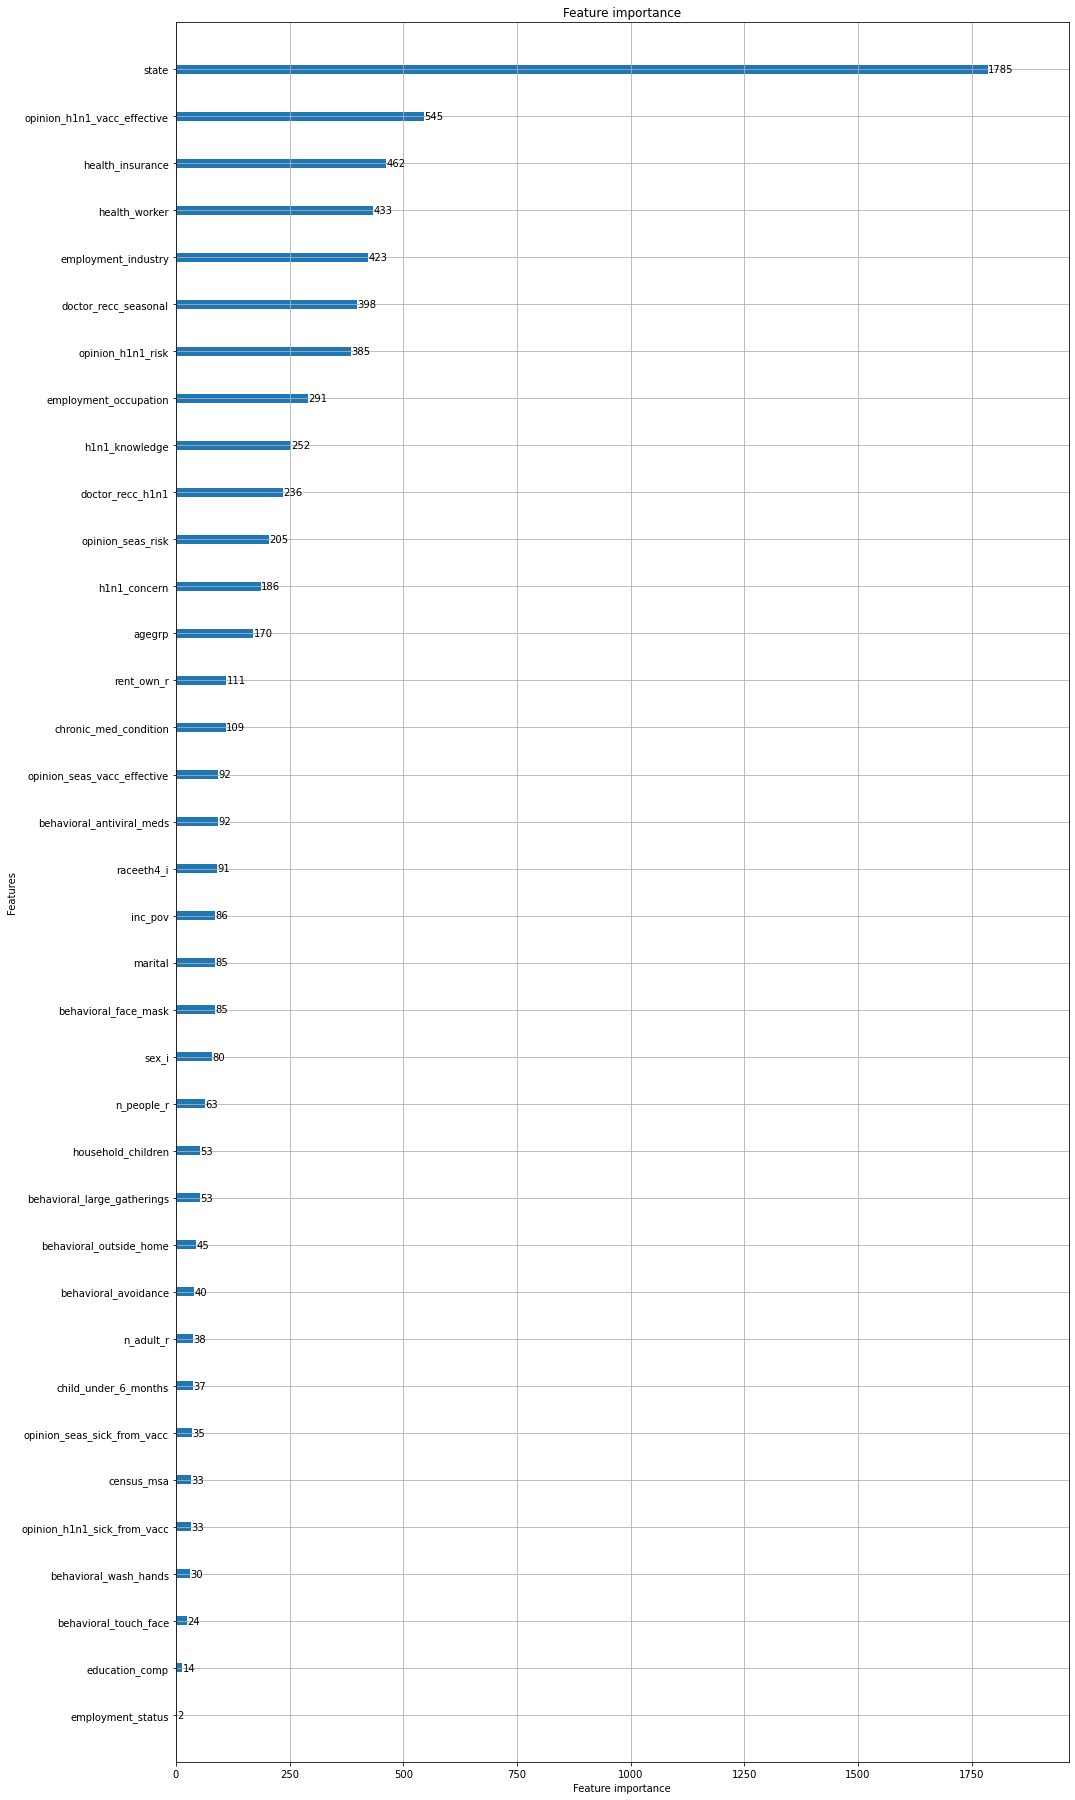

In [222]:
plot_importance(clf,figsize=(16,32))

In [12]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

accuracy : 0.8124774178007949
precision : 0.600739371534196
recall : 0.6522829904666332
f1 : 0.6254510464277123


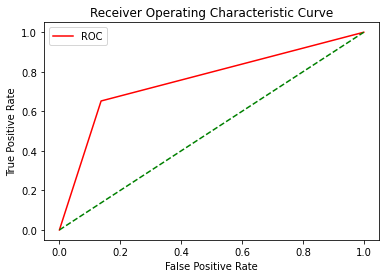

In [223]:
a=accuracy_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'accuracy : {a}')
p = precision_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'precision : {p}')
r = recall_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'recall : {r}')
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'f1 : {f1}')
fper, tper, thresholds = roc_curve(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
plot_roc_curve(fper, tper)

### Sampling

In [225]:
# cluster sampling
X_train = type_casting(train,type_feature).iloc[train_index]
y_train = target['vacc_h1n1_f'].iloc[train_index]
X_test = type_casting(train,type_feature).iloc[test_index]
y_test = target['vacc_h1n1_f'].iloc[test_index]
X_val = type_casting(train,type_feature).iloc[validate_index]
y_val = target['vacc_h1n1_f'].iloc[validate_index]
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
lgbBO.maximize(init_points=5, n_iter=25)
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
clear_output()

In [226]:
f1

0.6153112330073933

### Encoding

#### One Hot Encoding

In [227]:
X_train, X_test, y_train, y_test = train_test_split(encoder(type_casting(train,type_feature),type_feature),target['vacc_h1n1_f'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
lgbBO.maximize(init_points=5, n_iter=25)
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
clear_output()

In [228]:
f1

0.6345679012345679

#### Catboost Encoding

In [156]:
from category_encoders.cat_boost import CatBoostEncoder
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(train, target['vacc_h1n1_f'],cols=[x for x in train.columns if type_feature[x]=='nominal'])

In [230]:
X_train, X_test, y_train, y_test = train_test_split(train_cbe,target['vacc_h1n1_f'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
lgbBO.maximize(init_points=5, n_iter=25)
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
clear_output()

In [231]:
f1

0.632295719844358

In [157]:
def simple_train(train,target):
    X_train, X_test, y_train, y_test = train_test_split(train,target['vacc_h1n1_f'], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
    lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
    lgbBO.maximize(init_points=5, n_iter=25)
    max_target_param={'target':0}
    for i in range(len(lgbBO.res)):
        if lgbBO.res[i]['target']>max_target_param['target']:
            max_target_param=lgbBO.res[i]
    clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=int(max_target_param['params']['num_leaves'])+1,
        min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
        max_depth=int(max_target_param['params']['max_depth']),
        min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
        min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
        reg_alpha=round(max_target_param['params']['reg_alpha'],3),
        reg_lambda=round(max_target_param['params']['reg_lambda'],3),
        silent=-1,
        verbose=-1,
        scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
    )
    clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
    f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
    clear_output();
    return f1

### Feature Engineering

#### Feature Selection

##### Filter method

- Information value

In [257]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        
        if round(d['IV'].sum(),6)>0.5:
          print('***********************************found************************')

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [258]:
iv, woe = iv_woe(data = df.drop('vacc_seas_f',axis=1), target = 'vacc_h1n1_f', bins=10, show_woe = True)

Information value of h1n1_concern is 0.084292
       Variable  Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_concern     0.0   4209     590     0.082935        3619   
1  h1n1_concern     1.0  10293    1762     0.247681        8531   
2  h1n1_concern     2.0  13441    3083     0.433371       10358   
3  h1n1_concern     3.0   5791    1679     0.236013        4112   

   % of Non-Events       WoE        IV  
0         0.135950 -0.494232  0.026202  
1         0.320473 -0.257659  0.018756  
2         0.389106  0.107742  0.004769  
3         0.154470  0.423887  0.034565  
Information value of h1n1_knowledge is 0.09459
         Variable  Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_knowledge     0.0   3222     431     0.060585        2791   
1  h1n1_knowledge     1.0  18510    3352     0.471184       15158   
2  h1n1_knowledge     2.0  12002    3331     0.468232        8671   

   % of Non-Events       WoE        IV  
0         0.104846 -0.548449  0.024275  
1      

In [259]:
iv[iv['IV']>0.6]

,Variable,IV
0,doctor_recc_h1n1,0.791771
0,opinion_h1n1_risk,0.602018


In [260]:
iv_list = iv[iv['IV']>0.6]['Variable'].tolist()

In [261]:
iv_list

['doctor_recc_h1n1', 'opinion_h1n1_risk']

- variance filter

In [341]:
def var_filter(df):
    df_temp=df[:]
    cols=[]
    for column in df_temp.columns:
        if df_temp[column].var()<0.05:
            cols.append(column)
    return df_temp.drop(cols,axis=1)

In [346]:
varf=var_filter(train_cbe)
varf = varf.columns.tolist()
print(varf)

['h1n1_concern', 'h1n1_knowledge', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_insurance', 'health_worker', 'agegrp', 'education_comp', 'sex_i', 'inc_pov', 'marital', 'rent_own_r', 'census_msa', 'n_adult_r', 'household_children', 'n_people_r']


- custom filter

In [389]:
custom_u = []
custom_c = []
for column in train.columns:
    c_value=0
    for uniq in df[column].dropna().unique():
        tg1 = df[df['vacc_h1n1_f']==1]
        tg0 = df[df['vacc_h1n1_f']==0]
        tg1u = tg1[tg1[column]==uniq]
        tg0u = tg0[tg0[column]==uniq]
        u_value = abs(len(tg1u)/len(tg1)-len(tg0u)/len(tg0))*(len(tg1u)+len(tg0u))/len(df[column].dropna())
        c_value+=u_value
        if type_feature[column]=='nominal':
            custom_u.append([f'{column},{uniq}',u_value])
    custom_c.append([column,c_value])
custom_u = pd.DataFrame(custom_u,columns=['name','value'])
custom_c = pd.DataFrame(custom_c,columns=['col','value'])


In [390]:
custom_u.sort_values(by='value',ascending=False).head(10)

,name,value
0,"h1n1_knowledge,1.0",0.076055
9,"opinion_h1n1_risk,Very Low",0.063035
4,"opinion_h1n1_vacc_effective,Somewhat Effective",0.055152
3,"opinion_h1n1_vacc_effective,Very Effective",0.053066
22,"opinion_seas_vacc_effective,Somewhat Effective",0.050740
10,"opinion_h1n1_risk,Somewhat Low",0.043929
21,"opinion_seas_vacc_effective,Very Effective",0.041605
27,"opinion_seas_risk,Somewhat Low",0.041502
29,"opinion_seas_risk,Very Low",0.034139
15,"opinion_h1n1_sick_from_vacc,Not Very Worried",0.031031


In [392]:
custom_c.sort_values(by='value',ascending=False).head(20)

,col,value
9,doctor_recc_h1n1,0.367475
13,health_insurance,0.244576
10,doctor_recc_seasonal,0.214839
14,health_worker,0.198240
16,opinion_h1n1_risk,0.140927
4,behavioral_face_mask,0.135930
15,opinion_h1n1_vacc_effective,0.131317
2,behavioral_antiviral_meds,0.126331
19,opinion_seas_risk,0.108199
1,h1n1_knowledge,0.103123


##### wrapper method

- Feature Importance

In [343]:
X_train, X_test, y_train, y_test = train_test_split(type_casting(train,type_feature),target['vacc_h1n1_f'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=42)
lgbBO.maximize(init_points=5, n_iter=25)
max_target_param={'target':0}
for i in range(len(lgbBO.res)):
    if lgbBO.res[i]['target']>max_target_param['target']:
        max_target_param=lgbBO.res[i]
clear_output()

In [344]:
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=int(max_target_param['params']['num_leaves'])+1,
    min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
    max_depth=int(max_target_param['params']['max_depth']),
    min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
    min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
    reg_alpha=round(max_target_param['params']['reg_alpha'],3),
    reg_lambda=round(max_target_param['params']['reg_lambda'],3),
    silent=-1,
    verbose=-1,
    scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
)
clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))

c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=78 will be ignored. Current value: min_data_in_leaf=6
[1]	training's binary_logloss: 0.543937	valid_1's binary_logloss: 0.543028
[2]	training's binary_logloss: 0.540521	valid_1's binary_logloss: 0.539884
[3]	training's binary_logloss: 0.537255	valid_1's binary_logloss: 0.536875
[4]	training's binary_logloss: 0.53411	valid_1's binary_logloss: 0.533982
[5]	training's binary_logloss: 0.531093	valid_1's binary_logloss: 0.53123
[6]	training's binary_logloss: 0.528185	valid_1's binary_logloss: 0.528562
[7]	training's binary_logloss: 0.525395	valid_1's binary_logloss: 0.526013
[8]	training's binary_logloss: 0.522719	valid_1's binary_logloss: 0.523592
[9]	training's binary_logloss: 0.520128	valid_1's binary_logloss: 0.521241
[10]	training's binary_logloss: 0.517619	valid_1's binary_logloss: 0.518952
[11]	training's binary_logloss: 0.515201	valid_1's binary_logloss: 0.51678
[12]	training's binary_logloss: 0.512852	valid_1's binar

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

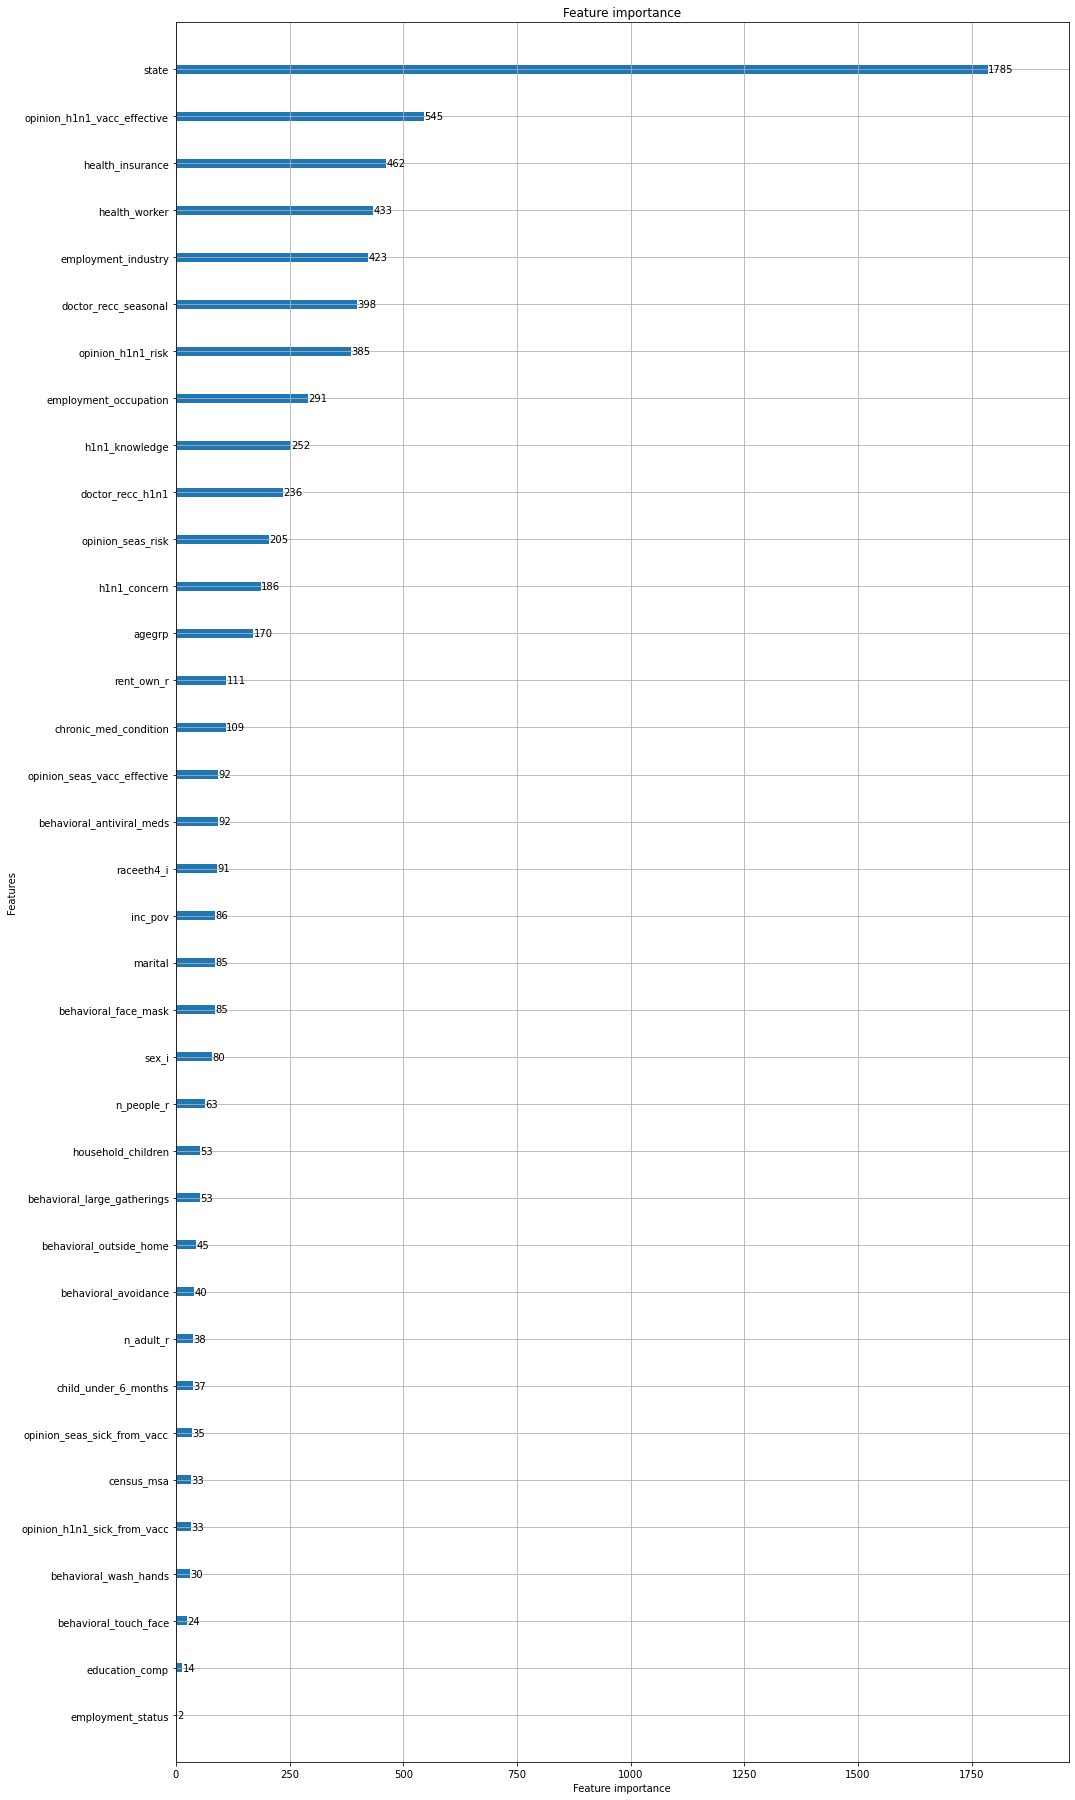

In [345]:
plot_importance(clf,figsize=(16,32))

In [347]:
f_i = pd.DataFrame(np.column_stack((list(map(lambda x:x/sum(clf.feature_importances_),clf.feature_importances_)),X_train.columns)),columns=['f_i','col']).sort_values(by='f_i',ascending=False).reset_index(drop=True)

In [348]:
f_i=f_i['col'].head(10).tolist()

In [349]:
f_i

['state',
 'opinion_h1n1_vacc_effective',
 'health_insurance',
 'health_worker',
 'employment_industry',
 'doctor_recc_seasonal',
 'opinion_h1n1_risk',
 'employment_occupation',
 'h1n1_knowledge',
 'doctor_recc_h1n1']

accuracy : 0.8264482717090208
precision : 0.6461864406779662
recall : 0.6121424987456097
f1 : 0.6287039422829167


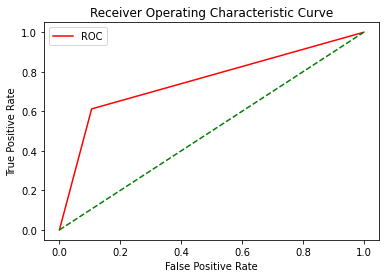

In [335]:
a=accuracy_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'accuracy : {a}')
p = precision_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'precision : {p}')
r = recall_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'recall : {r}')
f1 = f1_score(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
print(f'f1 : {f1}')
fper, tper, thresholds = roc_curve(y_test, list(map(round,clf.predict_proba(X_test)[:,1])))
plot_roc_curve(fper, tper)


- Akaike Information Criterion

In [311]:
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm
def all_aic(train,target):
    aic=[]
    for column in train.columns:
        x = train[column].dropna()
        y=target[x.index]
        model = Logit(np.array(y),np.array(sm.add_constant(x),dtype=float)).fit(method='bfgs')
        aic.append([column,model.aic,model.bic])
    return pd.DataFrame(aic,columns=['col','aic','bic'])

In [312]:
aic = all_aic(train_cbe,target['vacc_h1n1_f'])
clear_output()

In [316]:
aic.sort_values(by=['aic']).reset_index(drop=True)

,col,aic,bic
0,health_insurance,27825.634945,27841.668310
1,h1n1_knowledge,34236.859559,34253.712082
2,h1n1_concern,34292.190930,34309.043453
3,behavioral_avoidance,34458.024328,34474.861854
4,behavioral_touch_face,34476.129994,34492.972830
5,behavioral_wash_hands,34539.666119,34556.515616
6,behavioral_antiviral_meds,34560.714635,34577.561280
7,behavioral_face_mask,34569.160307,34586.011406
8,behavioral_large_gatherings,34635.107824,34651.954766
9,behavioral_outside_home,34654.179965,34671.026491


<AxesSubplot:>

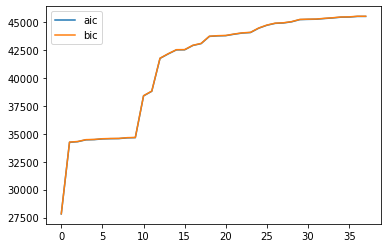

In [317]:
aic.sort_values(by=['aic']).reset_index(drop=True)[['aic','bic']].plot()

In [321]:
aic = aic[aic['aic']<35000].col.tolist()

In [327]:
aic

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'health_insurance']

In [354]:
selected=list((set(f_i) & set(varf))|set(aic)|set(iv_list))

In [355]:
selected

['h1n1_concern',
 'behavioral_outside_home',
 'opinion_h1n1_risk',
 'behavioral_large_gatherings',
 'behavioral_touch_face',
 'behavioral_wash_hands',
 'doctor_recc_h1n1',
 'h1n1_knowledge',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'health_worker',
 'behavioral_antiviral_meds',
 'health_insurance',
 'doctor_recc_seasonal']

##### Result of Feature Selection

In [376]:
res_fs_1 = simple_train(type_casting(train,type_feature)[selected],target)
res_fs_2 = simple_train(encoder(type_casting(train,type_feature)[selected],type_feature),target)
res_fs_3 = simple_train(train_cbe[selected],target)

In [377]:
print('baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358')
print(res_fs_1,res_fs_2,res_fs_3)

baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358
0.6048509348155634 0.599680170575693 0.6036569662631985


In [405]:
cusf=custom_c.sort_values(by='value',ascending=False)['col'].head(14).tolist()
res_cs_1 = simple_train(type_casting(train,type_feature)[cusf],target)
res_cs_2 = simple_train(encoder(type_casting(train,type_feature)[cusf],type_feature),target)
res_cs_3 = simple_train(train_cbe[cusf],target)

In [406]:
print('baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358')
print(res_cs_1,res_cs_2,res_cs_3)

baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358
0.6207243460764588 0.6225721784776902 0.6133886870783601


In [398]:
real_selected=list(set(selected)|set(cusf))
res_rs_1 = simple_train(type_casting(train,type_feature)[real_selected],target)
res_rs_2 = simple_train(encoder(type_casting(train,type_feature)[real_selected],type_feature),target)
res_rs_3 = simple_train(train_cbe[real_selected],target)


In [400]:
print('baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358')
print(res_rs_1,res_rs_2,res_rs_3)

baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358
0.6222444889779559 0.6236278097229482 0.6176171079429734


#### Feature Extraction

In [159]:
# EDA issue 1 : opinion
def fe1_1_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_vacc_effective.replace('Not At All Effective',1.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Not Very Effective',1.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Somewhat Effective',2.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Very Effective',3.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_vacc_effective'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_1_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_vacc_effective.replace('Not At All Effective',1.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Not Very Effective',2.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Somewhat Effective',3.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Very Effective',4.0,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_vacc_effective'] = 'ordinal'

    return df_temp, type_feature_temp

def fe1_2_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp.opinion_h1n1_risk.replace('Very Low',1.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat Low',2.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Dont Know',3.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Refused',3.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat High',4.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Very High',5.0,inplace=True)
    type_feature_temp['opinion_h1n1_risk'] = 'ordinal'
    return df_temp, type_feature_temp
    
def fe1_2_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp.opinion_h1n1_risk.replace('Very Low',0.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat Low',0.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Refused',np.nan,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Somewhat High',1.0,inplace=True)
    df_temp.opinion_h1n1_risk.replace('Very High',1.0,inplace=True)
    type_feature_temp['opinion_h1n1_risk'] = 'bool'
    return df_temp, type_feature_temp


def fe1_3_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_sick_from_vacc.replace('Not At All Worried',1.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Not Very Worried',2.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Somewhat Worried',3.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Very Worried',4.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_sick_from_vacc'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_3_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_h1n1_sick_from_vacc.replace('Not At All Worried',0.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Not Very Worried',0.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Somewhat Worried',1.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Very Worried',1.0,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_h1n1_sick_from_vacc.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_h1n1_sick_from_vacc'] = 'bool'

    return df_temp, type_feature_temp

def fe1_4_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_vacc_effective.replace('Not At All Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Not Very Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Somewhat Effective',2.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Very Effective',3.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_seas_vacc_effective'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_4_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_vacc_effective.replace('Not At All Effective',0.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Not Very Effective',0.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Somewhat Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Very Effective',1.0,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_seas_vacc_effective.replace('Refused',np.nan,inplace=True)
    type_feature_temp['opinion_seas_vacc_effective'] = 'bool'

    return df_temp, type_feature_temp
def fe1_5_1(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_risk.replace('Very Low',1.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat Low',2.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Dont Know',3.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Refused',3.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat High',4.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Very High',5.0,inplace=True)
    type_feature_temp['opinion_seas_risk'] = 'ordinal'

    return df_temp, type_feature_temp
def fe1_5_2(df,type_feature):
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)

    df_temp.opinion_seas_risk.replace('Very Low',0.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat Low',0.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Dont Know',np.nan,inplace=True)
    df_temp.opinion_seas_risk.replace('Refused',np.nan,inplace=True)
    df_temp.opinion_seas_risk.replace('Somewhat High',1.0,inplace=True)
    df_temp.opinion_seas_risk.replace('Very High',1.0,inplace=True)
    type_feature_temp['opinion_seas_risk'] = 'bool'

    return df_temp, type_feature_temp

In [173]:
temp1, temp2 = fe1_1_1(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_1_1_1 = simple_train(temp3,target)
f1_fe1_1_1_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_1_1_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_1_2(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_1_2_1 = simple_train(temp3,target)
f1_fe1_1_2_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_1_2_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_2_1(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_2_1_1 = simple_train(temp3,target)
f1_fe1_2_1_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_2_1_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_2_2(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_2_2_1 = simple_train(temp3,target)
f1_fe1_2_2_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_2_2_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_3_1(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_3_1_1 = simple_train(temp3,target)
f1_fe1_3_1_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_3_1_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_3_2(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_3_2_1 = simple_train(temp3,target)
f1_fe1_3_2_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_3_2_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_4_1(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_4_1_1 = simple_train(temp3,target)
f1_fe1_4_1_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_4_1_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_4_2(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_4_2_1 = simple_train(temp3,target)
f1_fe1_4_2_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_4_2_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_5_1(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_5_1_1 = simple_train(temp3,target)
f1_fe1_5_1_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_5_1_3 = simple_train(train_cbe,target)

temp1, temp2 = fe1_5_2(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe1_5_2_1 = simple_train(temp3,target)
f1_fe1_5_2_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe1_5_2_3 = simple_train(train_cbe,target)

In [181]:
res = [
    ['f1_fe1_1_1',
    f1_fe1_1_1_1,
    f1_fe1_1_1_2,
    f1_fe1_1_1_3],
    ['f1_fe1_1_2',
    f1_fe1_1_2_1,
    f1_fe1_1_2_2,
    f1_fe1_1_2_3],
    ['f1_fe1_2_1',
    f1_fe1_2_1_1,
    f1_fe1_2_1_2,
    f1_fe1_2_1_3],
    ['f1_fe1_2_2',
    f1_fe1_2_2_1,
    f1_fe1_2_2_2,
    f1_fe1_2_2_3],
    ['f1_fe1_3_1',
    f1_fe1_3_1_1,
    f1_fe1_3_1_2,
    f1_fe1_3_1_3],
    ['f1_fe1_3_2',
    f1_fe1_3_2_1,
    f1_fe1_3_2_2,
    f1_fe1_3_2_3],
    ['f1_fe1_4_1',
    f1_fe1_4_1_1,
    f1_fe1_4_1_2,
    f1_fe1_4_1_3],
    ['f1_fe1_4_2',
    f1_fe1_4_2_1,
    f1_fe1_4_2_2,
    f1_fe1_4_2_3],
    ['f1_fe1_5_1',
    f1_fe1_5_1_1,
    f1_fe1_5_1_2,
    f1_fe1_5_1_3],
    ['f1_fe1_5_2',
    f1_fe1_5_2_1,
    f1_fe1_5_2_2,
    f1_fe1_5_2_3]
    ]
res= pd.DataFrame(res, columns=['name','lgbmE','OHE','CBE'])
print('baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358')
print(res)

baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358
         name     lgbmE       OHE       CBE
0  f1_fe1_1_1  0.623973  0.633574  0.633519
1  f1_fe1_1_2  0.624548  0.634122  0.633107
2  f1_fe1_2_1  0.624367  0.631527  0.636010
3  f1_fe1_2_2  0.627759  0.629374  0.631239
4  f1_fe1_3_1  0.624970  0.632785  0.632608
5  f1_fe1_3_2  0.624103  0.633450  0.630909
6  f1_fe1_4_1  0.625925  0.632000  0.632499
7  f1_fe1_4_2  0.623954  0.633668  0.630964
8  f1_fe1_5_1  0.627329  0.633057  0.633178
9  f1_fe1_5_2  0.623154  0.631683  0.630705


- lgbmE : fe1_2_2, fe1_4_1, fe1_5_1
- OHE : x
- CBE : fe1_1_1, fe1_2_1, fe_1_3_1, fe1_4_1, fe_1_5_1

In [177]:
# EDA issue 2 : behavior
def fe2(df, type_feature):
    '''
    behavior score : sum of behavior inquiries (weight = 1)
    '''
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['behavior_score'] = df_temp['behavioral_antiviral_meds']+df_temp['behavioral_avoidance']+df_temp['behavioral_face_mask']+df_temp['behavioral_wash_hands']+df_temp['behavioral_large_gatherings']+df_temp['behavioral_outside_home']+df_temp['behavioral_touch_face']
    type_feature_temp['behavior_score'] = 'ratio'
    return df_temp, type_feature_temp

In [248]:
temp1, temp2 = fe2(train,type_feature)
f1_fe2_1 = simple_train(type_casting(temp1,temp2),target)
temp1, temp2 = fe2(train,type_feature)
temp1 = type_casting(temp1,temp2)
f1_fe2_2 = simple_train(encoder(temp1,temp2),target)
CBE_encoder = CatBoostEncoder()
temp1, temp2 = fe2(train_cbe,type_feature)
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe2_3 = simple_train(train_cbe,target)

In [249]:
print(f1_fe2_1)
print(f1_fe2_2)
print(f1_fe2_3)


0.6247619047619047
0.6347718865598028
0.629801810619036


In [250]:
def fe2_2(df, type_feature,w1,w2,w3,w4,w5,w6,w7):
    '''
    behavior score : sum of behavior inquiries (weight = 1)
    '''
    df_temp = copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['behavior_score'] = w1*df_temp['behavioral_antiviral_meds']+w2*df_temp['behavioral_avoidance']+w3*df_temp['behavioral_face_mask']+w4*df_temp['behavioral_wash_hands']+w5*df_temp['behavioral_large_gatherings']+w6*df_temp['behavioral_outside_home']+w7*df_temp['behavioral_touch_face']
    type_feature_temp['behavior_score'] = 'ratio'
    return df_temp, type_feature_temp

In [255]:
def fe2_2_eval(w1,w2,w3,w4,w5,w6,w7):
    param={
        'df':train,
        'type_feature':type_feature,
        'w1':w1,
        'w2':w2,
        'w3':w3,
        'w4':w4,
        'w5':w5,
        'w6':w6,
        'w7':w7
    }
    train_, type_feature_ = fe2_2(**param)
    f1 = simple_train(type_casting(train_,type_feature_), target)
    return f1

In [256]:
b_p={
    'w1':(0,1),
    'w2':(0,1),
    'w3':(0,1),
    'w4':(0,1),
    'w5':(0,1),
    'w6':(0,1),
    'w7':(0,1)
}

In [257]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
fe2fe2 = BayesianOptimization(fe2_2_eval,b_p , random_state=random_seed)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
fe2fe2.maximize(init_points=5, n_iter=25)
clear_output();

In [260]:
max_target_param={'target':0}
for i in range(len(fe2fe2.res)):
    if fe2fe2.res[i]['target']>max_target_param['target']:
        max_target_param=fe2fe2.res[i]

In [261]:
max_target_param['params']

{'w1': 0.06274118288143093,
 'w2': 0.9844194336163422,
 'w3': 0.230792818874879,
 'w4': 0.07324412868601282,
 'w5': 0.99100537047241,
 'w6': 0.8778262771966473,
 'w7': 0.8855500712474639}

In [262]:
weights={'w1': 0.06274118288143093,
 'w2': 0.9844194336163422,
 'w3': 0.230792818874879,
 'w4': 0.07324412868601282,
 'w5': 0.99100537047241,
 'w6': 0.8778262771966473,
 'w7': 0.8855500712474639}

In [264]:
temp1, temp2 = fe2_2(train,type_feature,**weights)
f1_fe2_1 = simple_train(type_casting(temp1,temp2),target)
temp1, temp2 = fe2_2(train,type_feature,**weights)
temp1 = type_casting(temp1,temp2)
f1_fe2_2 = simple_train(encoder(temp1,temp2),target)
CBE_encoder = CatBoostEncoder()
temp1, temp2 = fe2_2(train_cbe,type_feature,**weights)
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe2_3 = simple_train(train_cbe,target)

In [265]:
print(f1_fe2_1)
print(f1_fe2_2)
print(f1_fe2_3)

0.6291327264015333
0.6358871974045421
0.6300902218970982


In [179]:
# EDA issue 3 : high cardinality
def fe3_1(df,type_feature):
    df_temp=copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['Healthcare'] = np.logical_or(df_temp['employment_occupation'].map(lambda x: True if x=='Healthcare Practitioners and Technical Occupations' else False), df_temp['employment_industry'].map(lambda x: True if x=='Health Care and Social Assistance Industries' else False))
    type_feature_temp['Healthcare'] = 'bool'
    df_temp.drop(['state','employment_occupation','employment_industry'],axis=1,inplace=True)
    return df_temp, type_feature_temp

def fe3_2(df,type_feature):
    df_temp=copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp.drop(['state','employment_occupation','employment_industry'],axis=1,inplace=True)
    return df_temp, type_feature_temp

In [180]:
temp1, temp2 = fe3_1(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe3_1_1 = simple_train(temp3,target)
f1_fe3_1_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe3_1_3 = simple_train(train_cbe,target)

temp1, temp2 = fe3_2(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe3_2_1 = simple_train(temp3,target)
f1_fe3_2_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe3_2_3 = simple_train(train_cbe,target)


In [182]:
print('baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358')
print(f1_fe3_1_1)
print(f1_fe3_1_2)
print(f1_fe3_1_3)
print(f1_fe3_2_1)
print(f1_fe3_2_2)
print(f1_fe3_2_3)


baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358
0.6316550228860517
0.6313686313686314
0.6320963381666257
0.6291646547561565
0.6310054482417038
0.6297117516629712


- lgmbE : fe3_1
- OHE : x
- CBE : fe3_1

In [183]:
# EDA issue 4 : cluster
def fe4(df,type_feature):
    df_temp=copy.deepcopy(df)
    type_feature_temp = copy.deepcopy(type_feature)
    df_temp['cluster'] = clustering_results[0]
    type_feature_temp['cluster'] = 'nominal'

    return df_temp, type_feature_temp

In [184]:
temp1, temp2 = fe4(train,type_feature)
temp3 = type_casting(temp1,temp2)
f1_fe4_1 = simple_train(temp3,target)
f1_fe4_2 = simple_train(encoder(temp3,temp2),target)
CBE_encoder = CatBoostEncoder()
train_cbe = CBE_encoder.fit_transform(temp1, target['vacc_h1n1_f'],cols=[x for x in temp1.columns if temp2[x]=='nominal'])
f1_fe4_3 = simple_train(train_cbe,target)

In [185]:
print('baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358')
print(f1_fe4_1)
print(f1_fe4_2)
print(f1_fe4_3)

baseline :0.6254510464277123, 0.6345679012345679, 0.632295719844358
0.6264712947393707
0.6317365269461078
0.6302911671152434


- lgbmE : better
- OHE : worse
- CBE : worse

In [209]:
# EDA issue 5 : Imbalenced target
def fe5(train,target):
    n = len(target[target['vacc_h1n1_f']==1])
    a=np.array(train.iloc[target[target['vacc_h1n1_f']==0].index].sample(n,random_state=42,axis=0).index)
    b=np.array(target[target['vacc_h1n1_f']==1].index)
    return np.concatenate((a,b))

In [212]:
f1_fe5 = simple_train(type_casting(train.iloc[fe5(train,target)], type_feature),target.iloc[fe5(train,target)])

In [213]:
f1_fe5

0.7718137878402441

- sampling is better than lgbm's scale pos weight

In [246]:
# EDA issue 6 : students
def fe6(type_feature):
    def EDA_temp(df):
        df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
        df['agegrp'].replace('10 - 17 Years',2,inplace=True)
        df['agegrp'].replace('18 - 34 Years',3,inplace=True)
        df['agegrp'].replace('35 - 44 Years',4,inplace=True)
        df['agegrp'].replace('45 - 54 Years',5,inplace=True)
        df['agegrp'].replace('55 - 64 Years',6,inplace=True)
        df['agegrp'].replace('65+ Years',7,inplace=True)
        df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
        df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
        df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
        df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
        df['sex_i'].replace(2,0,inplace=True)
        df['inc_pov'].replace(4,np.nan,inplace=True)
        df['inc_pov'].replace(3,5,inplace=True)
        df['inc_pov'].replace(1,3,inplace=True)
        df['inc_pov'].replace(5,1,inplace=True)
        df['marital'].replace(2,0,inplace=True)
        df['rent_own_r'].replace(77,np.nan,inplace=True)
        df['rent_own_r'].replace(99,np.nan,inplace=True)
        df['rent_own_r'].replace(2,0,inplace=True)
        df['census_region'].replace(1,'northeast',inplace=True)
        df['census_region'].replace(2,'midwest',inplace=True)
        df['census_region'].replace(3,'south',inplace=True)
        df['census_region'].replace(4,'west',inplace=True)
        df['census_msa'].replace('Non-MSA',0,inplace=True)
        df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
        df['census_msa'].replace('MSA, Principle City',2,inplace=True)
        df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
        df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
        df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
        df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
        return df
    df_temp, train_temp, target_temp = data_init()
    df_temp = EDA_temp(df_temp)
    df_temp1 = df_temp[np.logical_or((df_temp['agegrp'] == 1), (df_temp['agegrp'] == 2))]
    df_temp2 = df_temp[np.logical_and((df_temp['agegrp'] != 1), (df_temp['agegrp'] != 2))]
    train1 = df_temp1.drop(['vacc_h1n1_f','vacc_seas_f'],axis=1)
    target1 = df_temp1['vacc_h1n1_f']
    train2 = df_temp2.drop(['vacc_h1n1_f','vacc_seas_f'],axis=1)
    target2 = df_temp2['vacc_h1n1_f']
    train1 = type_casting(train1,type_feature)
    train2 = type_casting(train2,type_feature)
    
    X_train, X_test, y_train, y_test1 = train_test_split(train1,target1, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
    lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
    lgbBO.maximize(init_points=5, n_iter=25)
    max_target_param={'target':0}
    for i in range(len(lgbBO.res)):
        if lgbBO.res[i]['target']>max_target_param['target']:
            max_target_param=lgbBO.res[i]
    clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=int(max_target_param['params']['num_leaves'])+1,
        min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
        max_depth=int(max_target_param['params']['max_depth']),
        min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
        min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
        reg_alpha=round(max_target_param['params']['reg_alpha'],3),
        reg_lambda=round(max_target_param['params']['reg_lambda'],3),
        silent=-1,
        verbose=-1,
        scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
    )
    clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
    res1 = list(map(round,clf.predict_proba(X_test)[:,1]))
    f1_1 = f1_score(y_test1, res1)

    X_train, X_test, y_train, y_test2 = train_test_split(train2,target2, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)
    lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
    lgbBO.maximize(init_points=5, n_iter=25)
    max_target_param={'target':0}
    for i in range(len(lgbBO.res)):
        if lgbBO.res[i]['target']>max_target_param['target']:
            max_target_param=lgbBO.res[i]
    clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=int(max_target_param['params']['num_leaves'])+1,
        min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
        max_depth=int(max_target_param['params']['max_depth']),
        min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
        min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
        reg_alpha=round(max_target_param['params']['reg_alpha'],3),
        reg_lambda=round(max_target_param['params']['reg_lambda'],3),
        silent=-1,
        verbose=-1,
        scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
    )
    clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
    res2 = list(map(round,clf.predict_proba(X_test)[:,1]))
    f1_2 = f1_score(y_test2, res2)
    y_test = np.concatenate((y_test1,y_test2))
    res = np.concatenate((res1,res2))
    f1 = f1_score(y_test, res)
    clear_output()
    return f1, f1_1, f1_2  

In [247]:
f1_fe6, f1_student, f1_adult = fe6(type_feature)

In [248]:
print('baseline :0.6254510464277123')
print(f1_fe6, f1_student, f1_adult)

baseline :0.6254510464277123
0.6233897448850719 0.6267029972752044 0.6221133659902031


- how about pred(train(student),test(student)) + pred(train(all),test(adult))?

In [254]:
def fe6_g(type_feature):
    def EDA_temp(df):
        df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
        df['agegrp'].replace('10 - 17 Years',2,inplace=True)
        df['agegrp'].replace('18 - 34 Years',3,inplace=True)
        df['agegrp'].replace('35 - 44 Years',4,inplace=True)
        df['agegrp'].replace('45 - 54 Years',5,inplace=True)
        df['agegrp'].replace('55 - 64 Years',6,inplace=True)
        df['agegrp'].replace('65+ Years',7,inplace=True)
        df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
        df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
        df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
        df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
        df['sex_i'].replace(2,0,inplace=True)
        df['inc_pov'].replace(4,np.nan,inplace=True)
        df['inc_pov'].replace(3,5,inplace=True)
        df['inc_pov'].replace(1,3,inplace=True)
        df['inc_pov'].replace(5,1,inplace=True)
        df['marital'].replace(2,0,inplace=True)
        df['rent_own_r'].replace(77,np.nan,inplace=True)
        df['rent_own_r'].replace(99,np.nan,inplace=True)
        df['rent_own_r'].replace(2,0,inplace=True)
        df['census_region'].replace(1,'northeast',inplace=True)
        df['census_region'].replace(2,'midwest',inplace=True)
        df['census_region'].replace(3,'south',inplace=True)
        df['census_region'].replace(4,'west',inplace=True)
        df['census_msa'].replace('Non-MSA',0,inplace=True)
        df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
        df['census_msa'].replace('MSA, Principle City',2,inplace=True)
        df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
        df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
        df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
        df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
        return df
    df_temp, train_temp, target_temp = data_init()
    train_all = EDA_temp(train_temp)
    train_all, X_test, target_all, y_test = train_test_split(train_all,target_temp['vacc_h1n1_f'], test_size=0.2, random_state=42)

    X_test1 = X_test[np.logical_or((X_test['agegrp'] == 1), (X_test['agegrp'] == 2))]
    X_test1 = type_casting(X_test1,type_feature)
    y_test1 = y_test[np.logical_or((X_test['agegrp'] == 1), (X_test['agegrp'] == 2))]

    X_test2 = X_test[np.logical_and((X_test['agegrp'] != 1), (X_test['agegrp'] != 2))]
    X_test2 = type_casting(X_test2,type_feature)
    y_test2 = y_test[np.logical_and((X_test['agegrp'] != 1), (X_test['agegrp'] != 2))]
    
    train_s = train_all[np.logical_or((train_all['agegrp'] == 1), (train_all['agegrp'] == 2))]
    train_s = type_casting(train_s,type_feature)
    target_s = target_all[np.logical_or((train_all['agegrp'] == 1), (train_all['agegrp'] == 2))]

    X_train, X_val, y_train, y_val = train_test_split(train_s,target_s, test_size=0.2, random_state=42)
    lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
    lgbBO.maximize(init_points=5, n_iter=25)
    max_target_param={'target':0}
    for i in range(len(lgbBO.res)):
        if lgbBO.res[i]['target']>max_target_param['target']:
            max_target_param=lgbBO.res[i]
    clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=int(max_target_param['params']['num_leaves'])+1,
        min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
        max_depth=int(max_target_param['params']['max_depth']),
        min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
        min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
        reg_alpha=round(max_target_param['params']['reg_alpha'],3),
        reg_lambda=round(max_target_param['params']['reg_lambda'],3),
        silent=-1,
        verbose=-1,
        scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
    )
    clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
    res1 = list(map(round,clf.predict_proba(X_test1)[:,1]))
    f1_1 = f1_score(y_test1, res1)

    train_all = type_casting(train_all,type_feature)
    X_train, X_val, y_train, y_val = train_test_split(train_all,target_all, test_size=0.2, random_state=42)
    lgbBO = BayesianOptimization(lgb_f1_eval,bayesian_params , random_state=random_seed)
    lgbBO.maximize(init_points=5, n_iter=25)
    max_target_param={'target':0}
    for i in range(len(lgbBO.res)):
        if lgbBO.res[i]['target']>max_target_param['target']:
            max_target_param=lgbBO.res[i]
    clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=500,
        learning_rate=0.01,
        num_leaves=int(max_target_param['params']['num_leaves'])+1,
        min_data_in_leaf=int(max_target_param['params']['min_data_in_leaf']),
        max_depth=int(max_target_param['params']['max_depth']),
        min_child_samples=int(max_target_param['params']['min_child_samples'])+1,
        min_child_weight=int(max_target_param['params']['min_child_weight'])+1,
        reg_alpha=round(max_target_param['params']['reg_alpha'],3),
        reg_lambda=round(max_target_param['params']['reg_lambda'],3),
        silent=-1,
        verbose=-1,
        scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]
    )
    clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='f1',verbose=1,early_stopping_rounds=100)
    res2 = list(map(round,clf.predict_proba(X_test2)[:,1]))
    f1_2 = f1_score(y_test2, res2)
    y_test = np.concatenate((y_test1,y_test2))
    res = np.concatenate((res1,res2))
    f1 = f1_score(y_test, res)
    clear_output()
    return f1, f1_1, f1_2  

In [255]:
f1_fe6_g, f1_student_g, f1_adult_g = fe6_g(type_feature)

In [256]:
print('baseline :0.6254510464277123')
print(f1_fe6, f1_student, f1_adult)
print(f1_fe6_g, f1_student_g, f1_adult_g)

baseline :0.6254510464277123
0.6233897448850719 0.6267029972752044 0.6221133659902031
0.6235177865612649 0.6386861313868613 0.6178861788617886


- hmm

In [ ]:
# feature extract using iv 


### Missing Value Imputation

#### Simple imputation

#### PMM imputation

#### Multiple imputation

In [ ]:
'''
strategy={}
for column in encoder(train_fe1,type_feature_fe1)[selected].columns:
    if len(encoder(train_fe1,type_feature_fe1)[selected][column].dropna().unique())==2:
        strategy[column]='bayesian binary logistic'
    else:
        strategy[column]='pmm'
strategy
'''

{'opinion_h1n1_risk_Very_Low': 'bayesian binary logistic',
 'behavioral_large_gatherings': 'bayesian binary logistic',
 'behavior_score': 'pmm',
 'doctor_recc_h1n1': 'bayesian binary logistic',
 'health_insurance': 'bayesian binary logistic',
 'health_worker': 'bayesian binary logistic',
 'doctor_recc_seasonal': 'bayesian binary logistic',
 'behavioral_avoidance': 'bayesian binary logistic',
 'behavioral_antiviral_meds': 'bayesian binary logistic',
 'behavioral_touch_face': 'bayesian binary logistic',
 'opinion_h1n1_vacc_effective_Very_Effective': 'bayesian binary logistic',
 'behavioral_outside_home': 'bayesian binary logistic',
 'behavioral_wash_hands': 'bayesian binary logistic',
 'opinion_h1n1_risk_Somewhat_Low': 'bayesian binary logistic',
 'h1n1_concern': 'pmm',
 'behavioral_face_mask': 'bayesian binary logistic'}

In [ ]:
'''
imp = MiceImputer(
    k=3,
    n=5,
    strategy=strategy, 
    imp_kwgs={"pmm": {"fill_value": "random",'neighbors':6}}, 
    #predictors={"salary": "all", "gender": ["salary", "education", "weight"]},
    visit="left-to-right", 
    return_list=True,
    seed=random_seed
    )
df_imputed=imp.fit_transform(encoder(train_fe1,type_feature_fe1)[selected].astype(float))
'''

C:\Users\gram\AppData\Roaming\Python\Python38\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gram\AppData\Roaming\Python\Python38\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\AppData\Roaming\Python\Python38\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


## XGBOOST & Grid search

## Output

In [ ]:
pred = clf.predict_proba(encoder(test,type_feature))
first_pred=pd.DataFrame(map(round,pred[:,1]),columns=['vacc_h1n1_f'])
first_pred.index.name='Id'
first_pred.to_csv('first_pred.csv')